## Basics

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt
#clustering
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt

2021-08-04 05:59:23,868- WARNING•	QuickBB solver is unavailable
2021-08-04 05:59:23,870- WARNING•	Tamaki solver is unavailable: No path /home/egupta/.local/lib/python3.7/site-packages/thirdparty/tamaki_treewidth


In [3]:
import torch

# Import Graphs

In [4]:
def mats_to_graphs(mat_list):
  """
  Given list of adjaceny matrix repr of graphs, converts to actual graphs
  """
  g_list = []
  for mat in mat_list:
    arr = np.array(mat)
    G = nx.convert_matrix.from_numpy_matrix(arr)
    g_list.append(G)
  return g_list

In [5]:
file2 = open("20NodeRandomLocalData.txt")
file3 = open("20NodeRandomGraphs.txt")
g_data = np.loadtxt(file2).reshape(55,20,4)
mat_list = np.loadtxt(file3).reshape(55,20,20)

In [6]:
g_list = mats_to_graphs(mat_list)

In [7]:
def find_max_energy_param(results):
    """
    Given multiple local optima, find the max
    """
    energies = []
    for i in range(len(results)):
        energies.append(results[i][2])
    i = np.argmax(energies)
    
    return results[i]

In [8]:
max_energies = [find_max_energy_param(i)[2] for i in g_data]
max_gammas = [find_max_energy_param(i)[0]%1 for i in g_data]
max_betas = [find_max_energy_param(i)[1]%0.5 for i in g_data]

In [15]:
arr = []
i = -1
for gam in max_gammas:
    i+=1
    if gam>0.8:
        arr.append(max_gammas[i])
np.mean(arr)

0.9156892572840055

In [124]:
ns = []
for i in range(len(g_list)):
    print(i)
    n = 0
    gamma = max_gammas[i]
    beta = max_betas[i]
    for j in range(len(g_list)):
        g = g_list[j]
        en = QAOA_energy(g, gamma = [gamma], beta = [beta])
        if en/max_energies[j] >0.98:
            n+=1
    ns.append(n)

0



1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25



26



27



28



29



30



31



32



33



34



35



36



37



38



39



40



41



42



43



44



45



46



47



48



49



50



51



52



53



54


In [125]:
def scatter_hist(x, y,c, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False, labelleft = False)
    ax_histy.tick_params(axis="y", labelleft=False, labelbottom = False)

    # the scatter plot:
    sc = ax.scatter(x, y, c=c)
    ax.set_xlim(0,0.5)
    ax.set_ylim(0,1)
    #plt.colorbar(sc, shrink = 3)
    #plt.show()
    # now determine nice limits by hand:
    binwidth = 0.005
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    #print(lim)

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, color = "silver")
    ax_histx.set_yticks([])
   
    ax_histy.hist(y, bins=bins, orientation='horizontal', color ='silver')
    ax_histy.set_xticks([])
    return sc

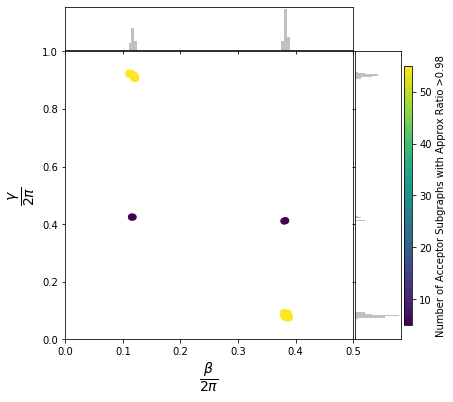

In [126]:
x = max_betas
y = max_gammas

# definitions for the axes
left, width = 0.0, 1
bottom, height = 0.0, 1
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.15]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(4,4))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
sc = scatter_hist(x, y,ns, ax, ax_histx, ax_histy)
cbar = plt.colorbar(sc, shrink = 10, aspect = 30, label = "Number of Acceptor Subgraphs with Approx Ratio >0.98")
#cbar.set_ylabel("Number of Acceptor Subgraphs with Approx Ratio >0.98")
ax.set_ylabel(r"$\frac{\gamma}{2\pi}$", fontsize = 20)
ax.set_xlabel(r"$\frac{\beta}{2\pi}$", fontsize = 20)
plt.show()
fig.savefig("fig_Distribution of graph optimal parameters.png", dpi = 100)

# Optimize Subgraphs

In [4]:
def sub_all(d1, d2, draw=False):
    # returns a list of subgraphs of all graphs with nodes of the central edge having degree d1 and d2
    A = np.zeros((d1 + d2, d1 + d2))
    A[d1 + 1:, d1] = 1
    A[:d1 - 1, d1 - 1] = 1
    A[d1 - 1, :d1 - 1] = 1
    A[d1, d1 + 1:] = 1
    A[d1, d1 - 1] = 1
    A[d1 - 1, d1] = 1
    
    g = nx.from_numpy_matrix(np.array(A))

    g_list = [g]
    for i in range(min(d1, d2) - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d1 + 1))
    # relabel center edge as (0, 1)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d1 - 1, d1))
        if draw:
            nx.draw_kamada_kawai(g)
            plt.show()
    return g_list

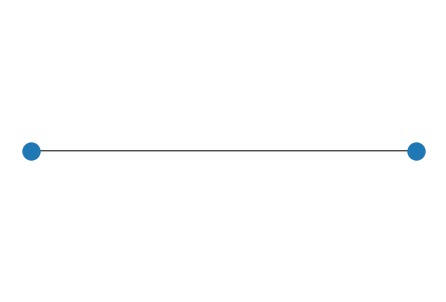

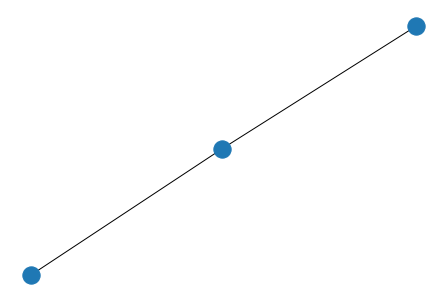

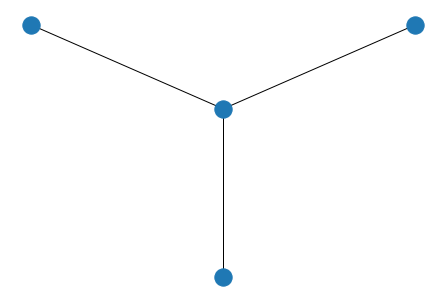

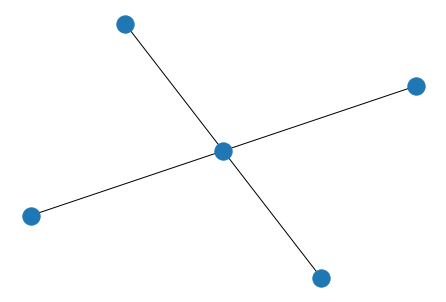

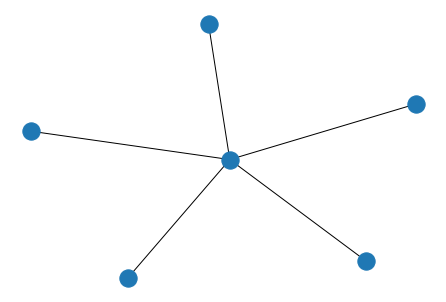

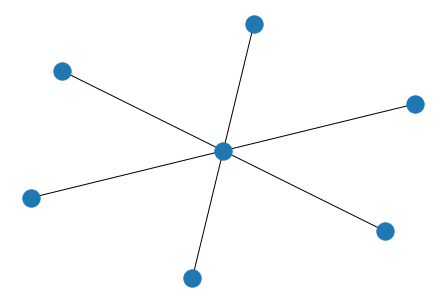

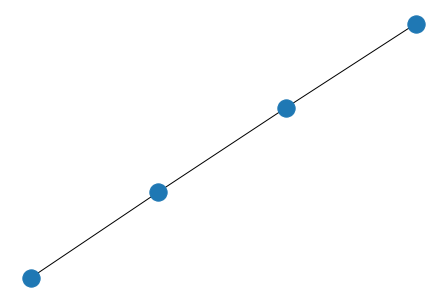

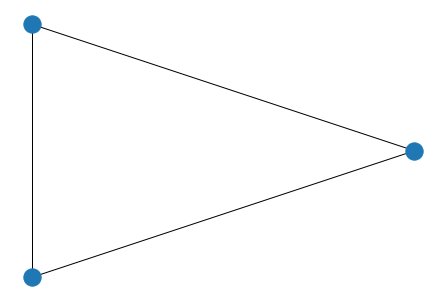

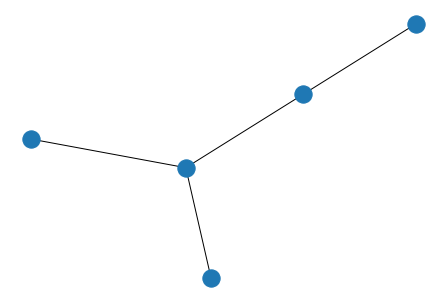

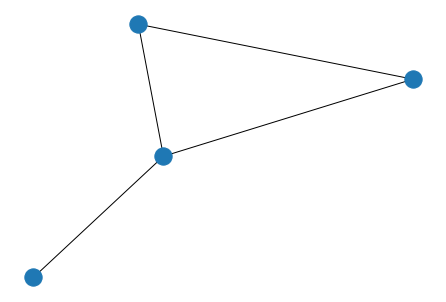

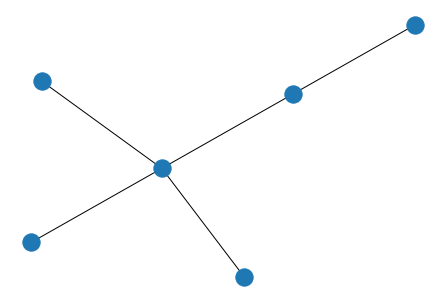

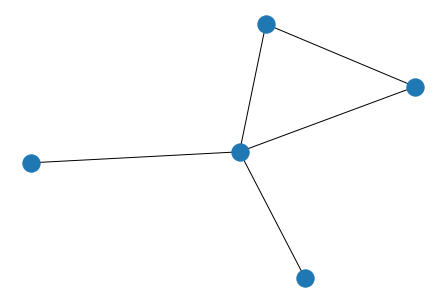

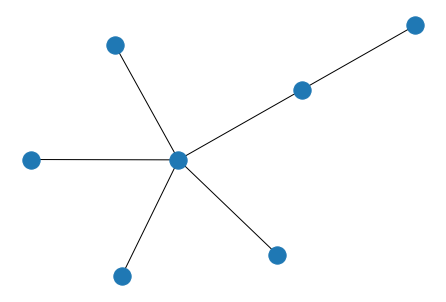

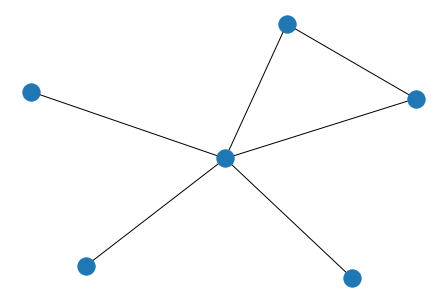

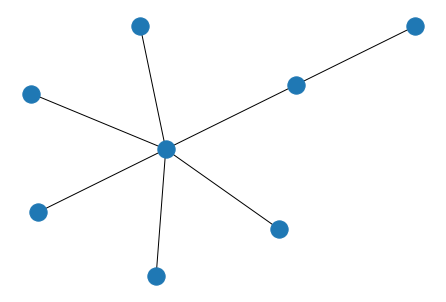

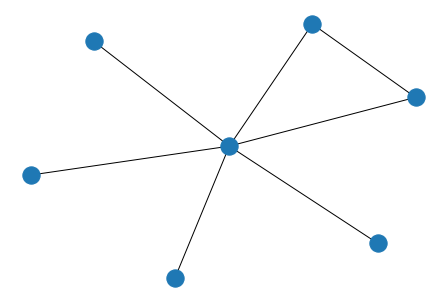

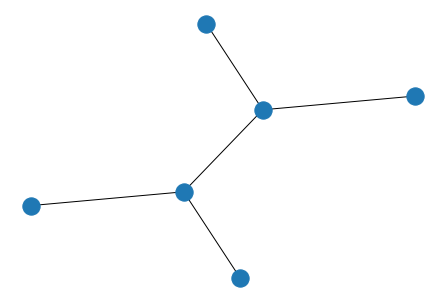

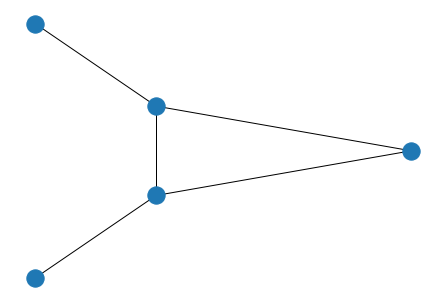

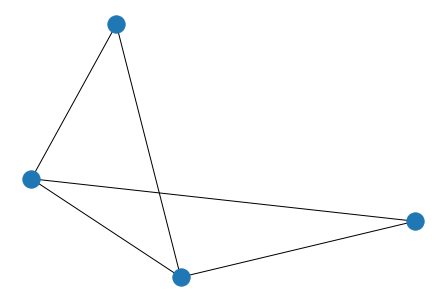

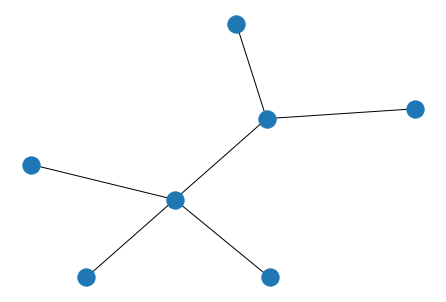

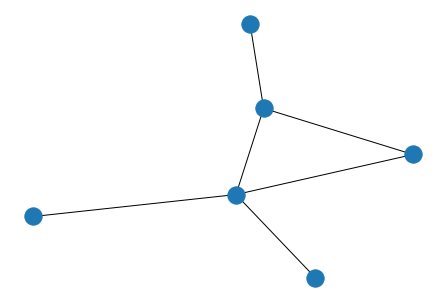

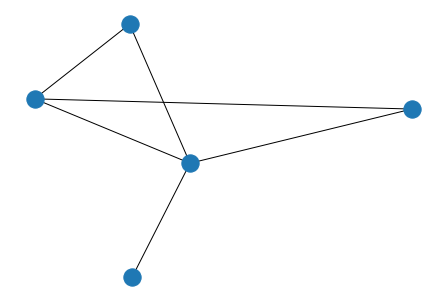

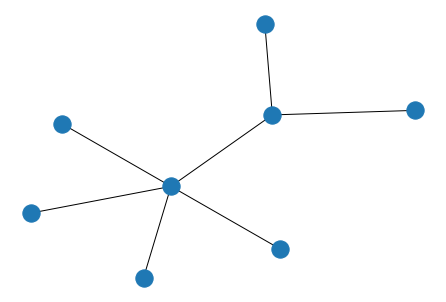

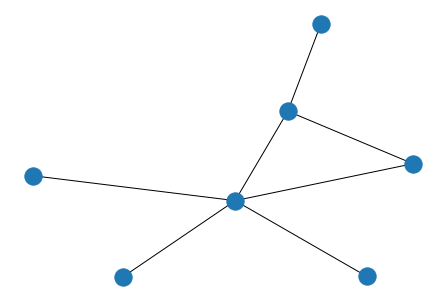

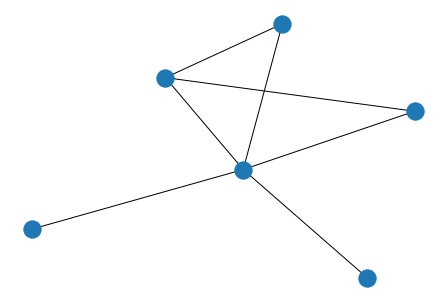

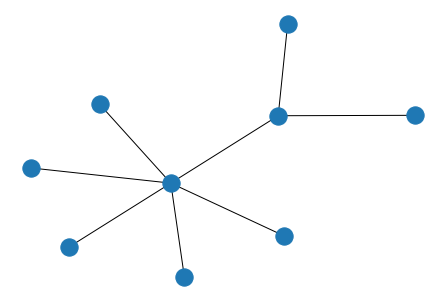

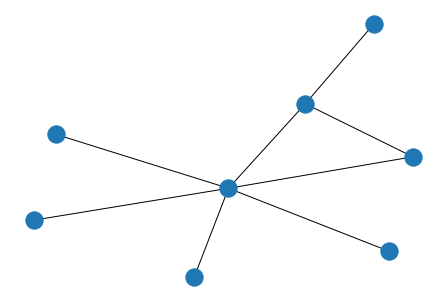

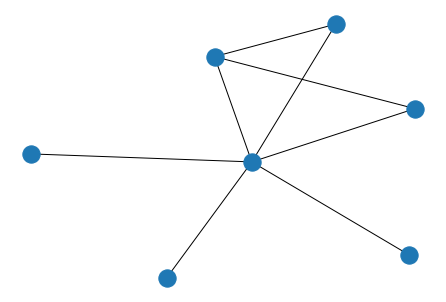

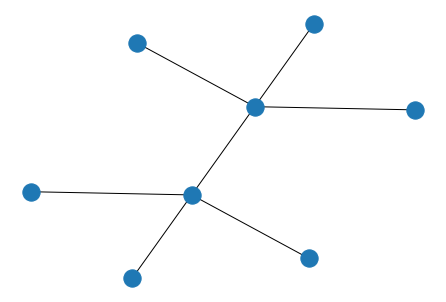

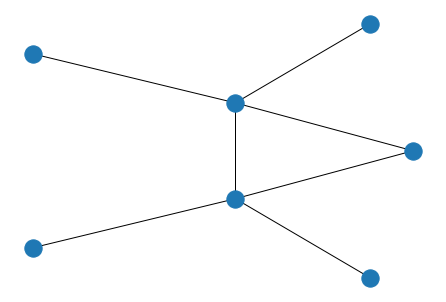

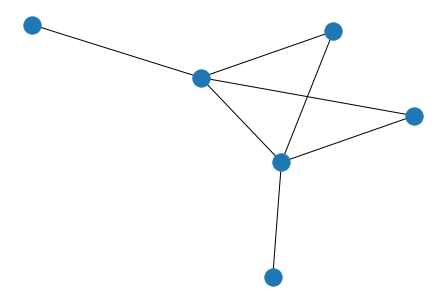

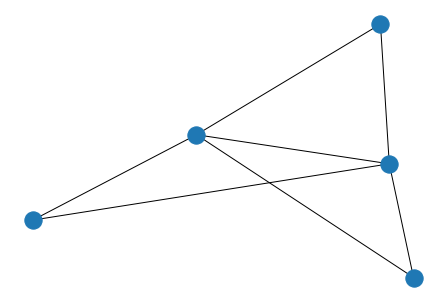

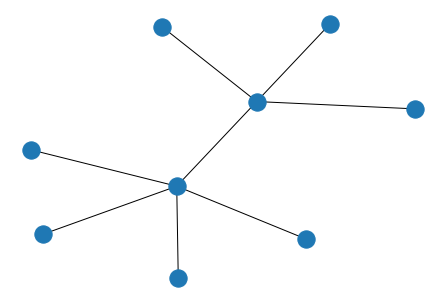

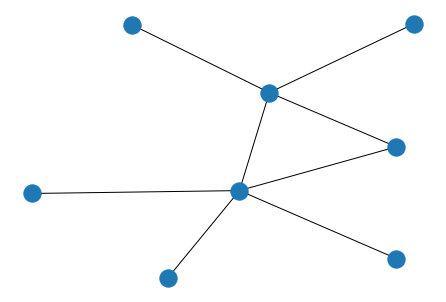

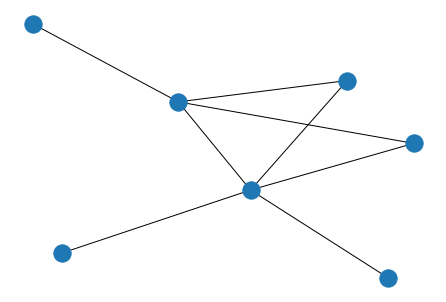

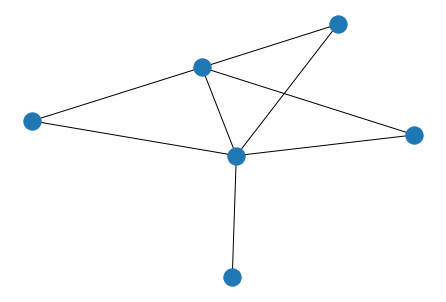

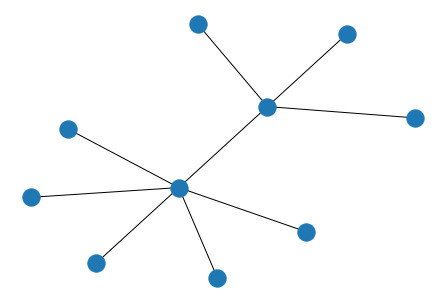

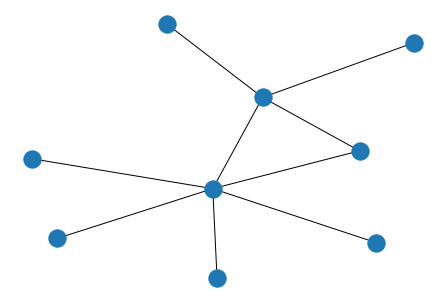

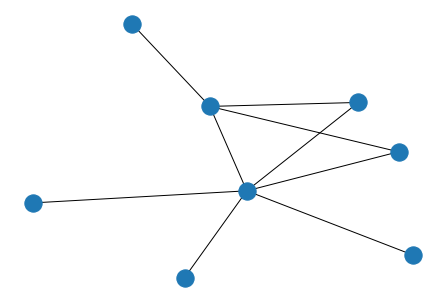

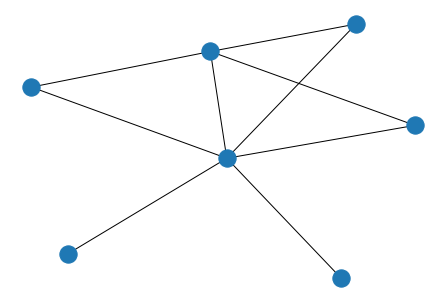

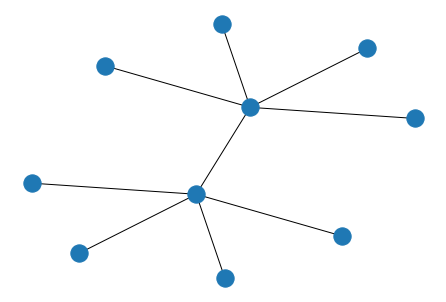

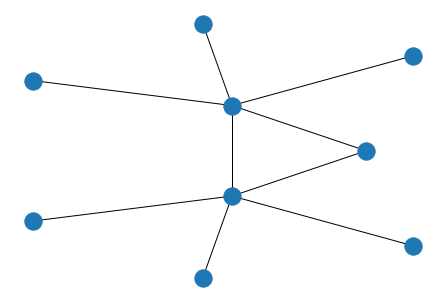

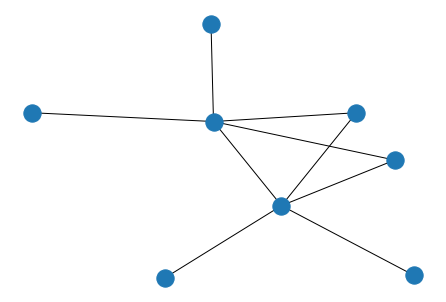

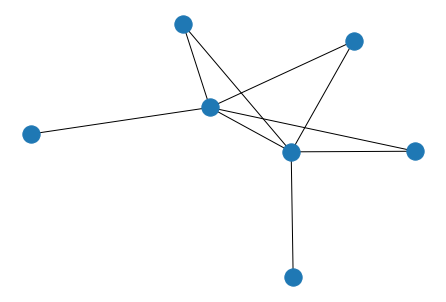

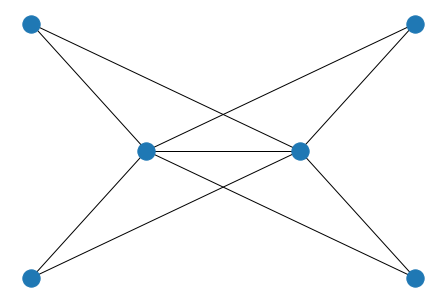

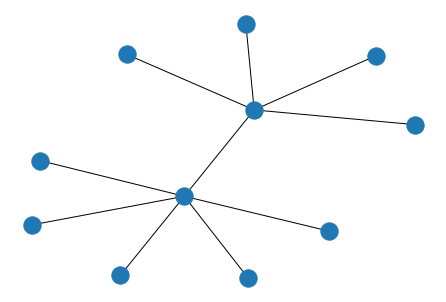

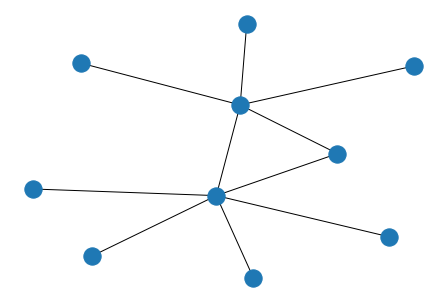

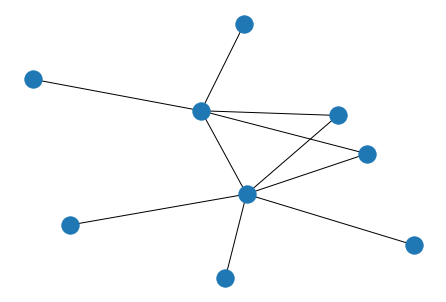

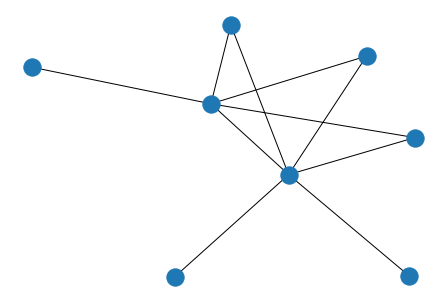

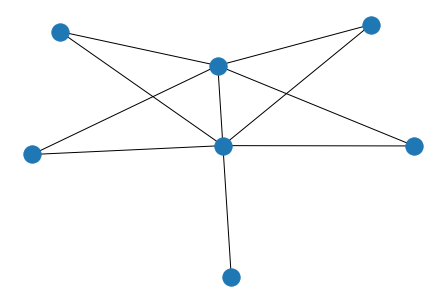

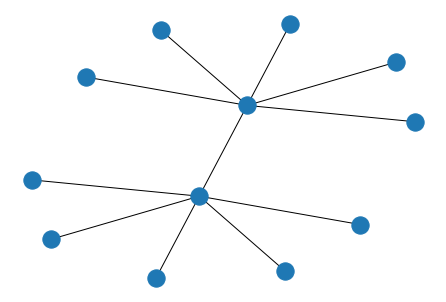

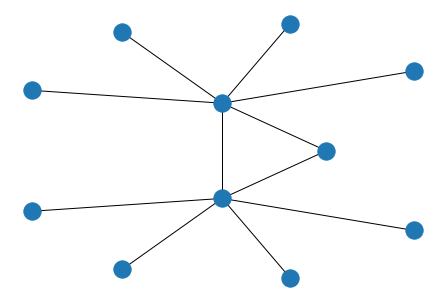

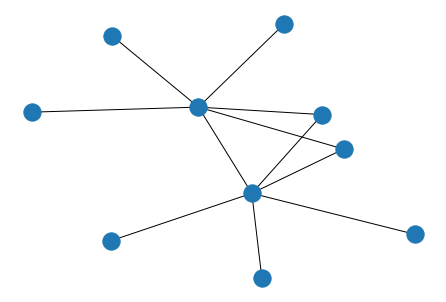

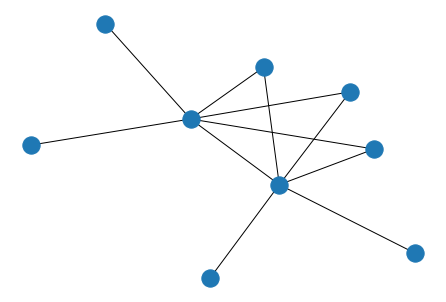

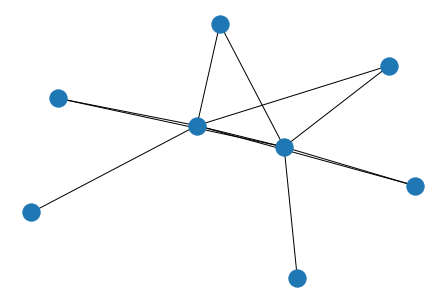

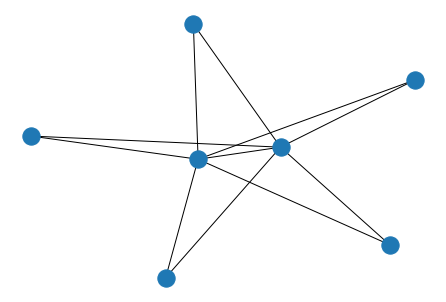

In [5]:
#generating all subgraphs first 
d_min = 1
d_max = 6
g_all = []
for i in range(d_min, d_max + 1):
    for j in range(i, d_max + 1):
        g_sub_ij = sub_all(i, j, draw=True)
        g_all += g_sub_ij

In [6]:
len(g_all)

56

In [7]:

def get_best_optima(subgraph,cutoff = 0.5, edge=(0,1), steps=50, multistarts =20):
    """
    Given a subgraph return those witin 10% of global
    """
    all_params = []
    all_energies = []
    for m in range(multistarts):
        
        p=1
        gamma = [np.random.rand() for i in range(p)]
        beta = [np.random.rand() for i in range(p)]
        loss_history, params_history = popt.qaoa_maxcut_torch(subgraph, gamma, beta,
                                                              ordering_algo='greedy',
                                                              Opt=torch.optim.RMSprop,
                                                              edge=edge,
                                                              opt_kwargs=dict(lr=0.002),
                                                              steps=steps,
                                                              pbar=False)
        energies_history = [(1-loss)/2 for loss in loss_history]
        
        all_params+=params_history
        all_energies+=energies_history
    
    #print(all_energies)
    best_index = np.argmax(all_energies)
    best_energy = float(all_energies[best_index])
    gamma, beta = all_params[best_index]
    
        
    return [float(gamma), float(beta), best_energy]

In [10]:
def get_edge_energy_contribution(graph, edge, gamma, beta):
    sim = qtensor.QtreeSimulator()
    composer = qtensor.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    return (1-np.real(sim.simulate_batch(composer.circuit)[0]))/2

In [11]:
# Best Optima I alrready did this in CLuster of CLusters file on July15
results = [[0.7500335574150085, 0.12499509006738663, 1.0000001788139343],
 [0.8333337306976318, 0.1249999925494194, 0.8247596323490143],
 [0.34795740246772766, 0.3749999403953552, 0.7721655964851379],
 [0.25000283122062683, 0.3749999403953552, 0.7500000596046448],
 [0.2500000298023224, -0.12499541789293289, 0.7500000596046448],
 [0.2499963641166687, 0.8750227689743042, 0.7500000894069672],
 [0.625, -0.12499973922967911, 0.7500000894069672],
 [0.5979548096656799, 0.90206378698349, 0.6666668057441711],
 [1.1107258796691895, 0.8750016093254089, 0.7174047976732254],
 [0.655762791633606, 0.28895244002342224, 0.7049064636230469],
 [0.60235196352005, 0.8750003576278687, 0.696800172328949],
 [0.40881094336509705, 1.1042331457138062, 0.6492285281419754],
 [0.09668959677219391, -0.1249830424785614, 0.6820307224988937],
 [0.08960944414138794, 0.3935889005661011, 0.6430598348379135],
 [0.40736865997314453, 0.1249999925494194, 0.6707032918930054],
 [0.4109976887702942, 0.60829097032547, 0.6379729956388474],
 [0.40204253792762756, -0.1249999925494194, 0.6924501806497574],
 [0.412660151720047, 0.3952995538711548, 0.6466836482286453],
 [0.5782284736633301, 0.5899081230163574, 0.6162528172135353],
 [0.09038052707910538, 0.8749999403953552, 0.6761299222707748],
 [0.08304359763860703, 0.3931071162223816, 0.6389948427677155],
 [0.6099771857261658, 0.23174257576465607, 0.6883674263954163],
 [0.5851067304611206, 0.6250003576278687, 0.6641375571489334],
 [0.07992248237133026, 0.3914003074169159, 0.6328345090150833],
 [0.42566242814064026, 0.4052582383155823, 0.6092553958296776],
 [0.08115101605653763, 0.3749999403953552, 0.6547541171312332],
 [0.9224380254745483, 0.10995934903621674, 0.6277190446853638],
 [0.40342622995376587, 0.29880741238594055, 0.6352367848157883],
 [0.583324134349823, 0.375, 0.6623798310756683],
 [0.4219731092453003, 0.10869038850069046, 0.6315252035856247],
 [0.0725332498550415, 0.4049520194530487, 0.6083499118685722],
 [0.5658159255981445, 0.41555023193359375, 0.590521365404129],
 [0.9215731024742126, 0.1249999925494194, 0.6521333903074265],
 [0.07445986568927765, 0.38992834091186523, 0.6256206333637238],
 [0.4095299541950226, 0.2337774932384491, 0.624472051858902],
 [0.4025651812553406, 0.2384955883026123, 0.6976248472929001],
 [0.42530858516693115, 1.1249996423721313, 0.6440232694149017],
 [0.571735143661499, 0.8888258337974548, 0.6207438185811043],
 [0.5683172941207886, 0.9012719392776489, 0.6020957455039024],
 [0.4364716708660126, 0.5882025361061096, 0.5869673937559128],
 [0.5738126039505005, 0.625, 0.6431084275245667],
 [0.5707079768180847, 1.111189603805542, 0.6199875995516777],
 [0.9327870607376099, 0.09882704168558121, 0.6015077829360962],
 [0.4374029040336609, 0.41159501671791077, 0.5865603610873222],
 [0.5574477910995483, 0.08021768182516098, 0.5746127367019653],
 [0.9297171831130981, 0.1249999925494194, 0.6359094977378845],
 [1.0678256750106812, 0.8878848552703857, 0.6153592094779015],
 [0.06501628458499908, 0.399658739566803, 0.5985869765281677],
 [0.5809909105300903, 0.7400120496749878, 0.6429338753223419],
 [0.4107972979545593, 0.7581223249435425, 0.7047160267829895],
 [0.566926121711731, 0.37499988079071045, 0.6294021606445312],
 [0.5649324059486389, 0.3870834708213806, 0.6109563484787941],
 [0.5625746250152588, 0.3983265459537506, 0.5956619828939438],
 [0.440633088350296, 0.5916891098022461, 0.5828935280442238],
 [0.5554376244544983, 0.9166286587715149, 0.5723293721675873],
 [0.55135577917099, 0.9232332110404968, 0.5636933892965317]]

In [15]:
betas = []
gammas = []
for i in range(len(results)):
    print(i)
    gamma = results[i][0]%1
    beta = results[i][1]%0.5
    
    betas.append(beta)
    gammas.append(gamma)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [25]:
ns = []
betas = []
gammas = []
for i in range(len(results)):
    print(i)
    gamma = results[i][0]%1
    beta = results[i][1]%0.5
    
    betas.append(beta)
    gammas.append(gamma)
    n = 0
    for j in range(len(g_all)):
        sub = g_all[j]
        best_e = results[j][2]
        e = get_edge_energy_contribution(graph = sub, edge = (0,1), gamma = [gamma], beta= [beta])
        if (e/best_e)>0.98:
            n+=1
    ns.append(n)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


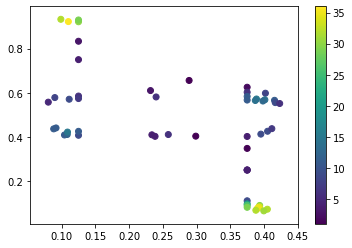

In [26]:
sc = plt.scatter(x = betas, y = gammas,c = ns )
plt.colorbar(sc)
plt.show()


In [115]:
def scatter_hist(x, y,c, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False, labelleft = False)
    ax_histy.tick_params(axis="y", labelleft=False, labelbottom = False)

    # the scatter plot:
    sc = ax.scatter(x, y, c=c)
    ax.set_xlim(0,0.5)
    ax.set_ylim(0,1)
    #plt.colorbar(sc, shrink = 3)
    #plt.show()
    # now determine nice limits by hand:
    binwidth = 0.005
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    #print(lim)

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, color = "silver")
    ax_histx.set_yticks([])
   
    ax_histy.hist(y, bins=bins, orientation='horizontal', color ='silver')
    ax_histy.set_xticks([])
    return sc

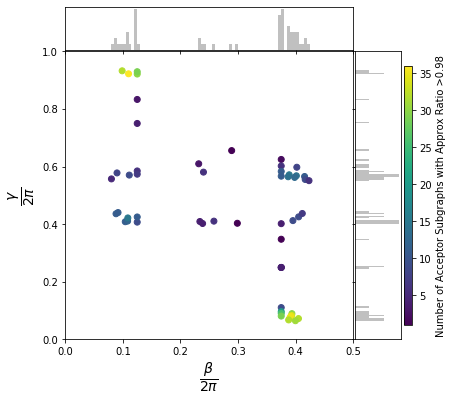

In [117]:
x = betas
y = gammas

# definitions for the axes
left, width = 0.0, 1
bottom, height = 0.0, 1
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.15]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(4,4))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
sc = scatter_hist(x, y,ns, ax, ax_histx, ax_histy)
cbar = plt.colorbar(sc, shrink = 10, aspect = 30, label = "Number of Acceptor Subgraphs with Approx Ratio >0.98")
#cbar.set_ylabel("Number of Acceptor Subgraphs with Approx Ratio >0.98")
ax.set_ylabel(r"$\frac{\gamma}{2\pi}$", fontsize = 20)
ax.set_xlabel(r"$\frac{\beta}{2\pi}$", fontsize = 20)
plt.show()
fig.savefig("fig_Distribution of subgraph optimal parameters.png", dpi = 100)

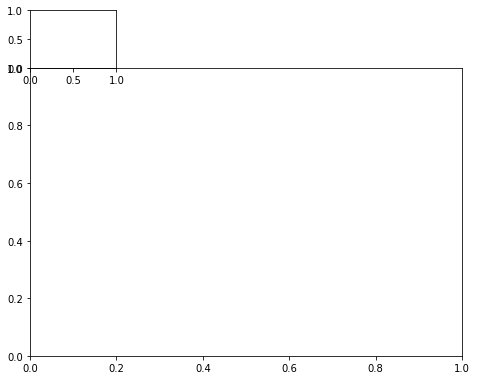

In [73]:
# Create figure() objects
# This acts as a container 
# for the different plots
fig=matplotlib.pyplot.figure() 
  
# Creating two axes
# add_axes([xmin,ymin,dx,dy])
axes=fig.add_axes([0,0,1,1]) 
axes1=fig.add_axes([0,1,0.2,0.2])
  
# Depict illustration
fig.show()

In [32]:
rect_scatter

[0.1, 0.1, 0.65, 0.65]

In [22]:
#There only seems to be information for a colorbar when effectively creating the colorbar. So, an idea is to combine both approaches: add a colorbar via kdeplot, and then move it to the desired location. This will leave the main joint plot with insufficient width, so its width also should be adapted:

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# create some dummy data: gaussian multivariate with 10 centers with each 1000 points
tumg = betas
pumg = gammas

kdeplot = sns.jointplot(x=tumg, y=pumg, kind="kde", color = ns)
# plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# # get the current positions of the joint ax and the ax for the marginal x
# pos_joint_ax = kdeplot.ax_joint.get_position()
# pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
# # reposition the joint ax so it has the same width as the marginal x ax
# kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# # reposition the colorbar using new x positions and y positions of the joint ax
# kdeplot.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])
# plt.show()

ValueError: RGBA sequence should have length 3 or 4

In [14]:
tumg

array([15.48321913, 19.93086371, 21.57748306, ..., 18.2685152 ,
       23.50691136, 13.60255912])

# Looking at Local Optima of all subgraphs

In [9]:
def get_edge_energy_contribution(graph, edge, gamma, beta):
    sim = qtensor.QtreeSimulator()
    composer = qtensor.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    return (1-np.real(sim.simulate_batch(composer.circuit)[0]))/2

In [36]:
step = 30
gamma = np.linspace(0, 1, num = step)
beta = np.linspace(0, 0.5, num = step)
data_1 = np.zeros((step, step))
data_2 = np.zeros((step, step))

In [37]:
subgraphs = g_all
for i in range(len(gamma)):
    print('#####')
    print(i)
    for j in range(len(beta)):
        print(j)
        s=0
        t = 0
        for sub_idx in range(len(subgraphs)):
            sub = g_all[sub_idx]
            e = get_edge_energy_contribution(graph = sub, edge = (0,1), gamma = [gamma[i]], beta= [beta[j]])
            best_en = results[sub_idx][2]
            print(e)
            
            s+= e/best_en
            
            if s>0.99:
                t+=1
        data_1[step -i-1][j] = s/len(subgraphs)
        data_2[step-i-1][j] = t

#####
0
0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
1
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
2
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
3
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
4
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.

0.4579131184562889
0.45694173887220857
0.4569537835270352
0.4559353392701966
0.45491689494363863
0.45745698329318124
0.45646234971392896
0.4554677160665872
0.45794841852883067
0.4569770389459586
0.4560056592965888
0.458428364282562
0.4574796950297798
0.4565310257120548
0.4579601830248798
0.45698880344241044
0.4560174237934433
0.4550437637364505
0.4584516182264844
0.4575029489744982
0.45655427965756895
0.4556033832473627
0.4589315639465641
0.45800507406939567
0.4570785841288025
0.45614991916320985
0.4589430533944467
0.4580165635176716
0.45709007357747167
0.45616140861227233
0.4552283936602011
0.4594229990812776
0.45851817003750484
0.45761334093179007
0.45670638765202465
0.4557951860858084
0.45990294473525284
0.459019270105904
0.4581355954160615
0.4572498462142479
0.4563599480487022
0.45546382159753707
3
0.4349527207306649
0.4357131075520555
0.43645571695272506
0.4371809645594852
0.4378892562820097
0.43858098854001626
0.43647349432139226
0.43411774078533216
0.4372161036706165
0.434915426

0.4160919048915225
0.3992911029268751
0.41703797814465937
0.4006299701204283
0.4151469289044186
0.3979439298420648
0.3807409296020438
0.4161388405991175
0.3993380386360768
0.3825372355229022
0.4171075619504033
0.40069955392855405
0.3842915447834604
0.41805363513639326
0.4020292377385394
0.3860048392437021
0.41713075222591317
0.40072274420485754
0.3843147350605577
0.3678682064715314
0.41809947351008947
0.40207507611380455
0.38605067762053624
0.36998866024704113
0.4190455466297451
0.4033957912421765
0.38774603478327146
0.37205953895391175
0.4190681947279501
0.40341843934115673
0.3877686828830269
0.3720821870544424
0.35632221355125515
0.4200142677820652
0.40473039547025025
0.389446522112146
0.3741267683308801
0.35873525474466766
0.420960340771415
0.4060337973801365
0.3911072529670305
0.3761456669963167
0.36111399892741713
0.3459771259561683
11
0.4260824773588765
0.4269465551607078
0.4277904313044004
0.42861457809417064
0.42941945679200894
0.4302055178758412
0.42781063290338694
0.407870081

0.5492325031213358
0.531479056291036
0.5137256082453869
0.4959304821912842
0.4780520013299172
0.4600483910191529
18
0.5739175226411235
0.5730534448392922
0.5722095686955997
0.5713854219058294
0.5705805432079911
0.5697944821241588
0.572189367096613
0.552248820491306
0.5713454910113812
0.5518711440000064
0.5705213442793964
0.5515022973589352
0.5697164656386839
0.5511420741308058
0.5689304046113334
0.5507902727047276
0.5705016149839185
0.5514825680627821
0.532463519839657
0.5696774683090275
0.5511030767998146
0.5325286840190531
0.5688725897247495
0.5507324578161649
0.5325923246657596
0.5680865287531892
0.550370503682576
0.5326544773991753
0.5688533216905554
0.5507131897813111
0.5325730566302462
0.5143903376869827
0.5680484431620363
0.5503324180901195
0.532616391805415
0.5148587753620918
0.567262382245591
0.5499605486146479
0.5326587137992718
0.5153162611814636
0.5672435646886169
0.5499417310570298
0.5326398962410095
0.5152974436225571
0.49787375657811267
0.566457503826627
0.54956017805581

0.5660395147351922
0.5626602556518325
0.5592651676460075
0.5558463177910746
26
0.5650472792693352
0.5642868924479445
0.563544283047275
0.5628190354405149
0.5621107437179904
0.5614190114599837
0.5635265056786077
0.5611707564913871
0.5627838963293835
0.5604832233532135
0.5620586487734744
0.5598117643553061
0.5613503571012206
0.5591560036926605
0.5606586248929178
0.5585155743463974
0.5620412870309961
0.5597944026122335
0.5575475180396556
0.5613160395253296
0.5591216861155949
0.5569273325556411
0.5606077479027378
0.5584646973544761
0.5563216466595071
0.5599160157435304
0.5578230686226348
0.555730121358462
0.5605907920693113
0.558447741520469
0.5563046908249198
0.5541566090974981
0.5598825004957875
0.5577895533737446
0.5556966061084248
0.5535987454341298
0.5591907683850811
0.5571467532978871
0.5551027380707659
0.5530539243076054
0.5591742089707512
0.5571301938829905
0.5550861786553023
0.553037364891575
0.5509789541950395
0.5584824769079655
0.5564862498490816
0.5544900226535419
0.55248910910

0.33538735197471997
0.35871912476344403
0.34282201332090867
0.34721439358068484
0.32791459468175055
0.30861479446160855
0.35427497134545205
0.3367589486180615
0.3192429246915752
0.36068297819576645
0.34478586682045076
0.3288887543568654
0.36649872774480335
0.3520709004689656
0.3376430722054412
0.3613355486268727
0.3454384372738938
0.32954132483264487
0.31291588561884914
0.3677435550161773
0.3533157277829484
0.33888789956203247
0.32379905988749025
0.37355930412447647
0.3604649629972024
0.3473706209735279
0.33367636122295535
0.3741515609668086
0.36105721985980654
0.3479628778564042
0.33426861812610376
0.31937452375627057
0.37996730965670666
0.36808320773891556
0.3561991050075737
0.34377053171211075
0.3302530180274108
0.38578305794847567
0.37499733935153745
0.3642116200162404
0.35293175259712684
0.34066358968108273
0.3268903444346301
6
0.29770794351467683
0.30705632933113514
0.3155406945413272
0.3232408959140236
0.3302294094871742
0.33657201272908577
0.3164047145076304
0.284119767308226
0

0.2276381746513892
13
0.43296438828125555
0.43606225960985406
0.4388738114907937
0.4414255068877589
0.4437413629352992
0.44584317699363657
0.4391601307263814
0.3533139848781841
0.4419716824050502
0.3640598331303122
0.444523377608639
0.37381250062987337
0.4468392334708754
0.38266378172196774
0.44894104735123525
0.39069698669502123
0.44478323389124846
0.3740723569213773
0.30336147511084544
0.44733492891126125
0.3831594771793205
0.3189840210541152
0.449650784597994
0.39140672396607323
0.33316265934693373
0.4517525983101766
0.3988917222608305
0.3460308425927827
0.44988662375659244
0.39164256313274415
0.333398498521677
0.2724859792984348
0.45220247927671614
0.39934160324276885
0.34648072359011983
0.2911980202058486
0.454304292829616
0.40632906264178575
0.3583538291697109
0.30818060808327397
0.45451833463830316
0.40654310445779923
0.3585678709930509
0.30839464991394017
0.253825456589414
0.4566201480399927
0.41307900979351886
0.3695378685663455
0.3240018878759163
0.274476230966553
0.458721961

0.5955790725787186
0.5649486865547285
0.5329149676874867
0.49807458503847235
0.620094435431335
0.5922950530254891
0.5644956687165784
0.5354226540571099
0.5038023804252126
0.468302867757739
21
0.7071788367900411
0.6976046215046334
0.6889152990186711
0.68102908345904
0.6738717479801661
0.6673759261238328
0.6880304068746482
0.6368228853091755
0.67934108501382
0.6328663990269098
0.6714548700518337
0.6292755891543458
0.6642975351456561
0.6260166581914206
0.6578017138393764
0.6230589323588812
0.670651763747837
0.62847248282286
0.586293199010412
0.662765549353207
0.6244846723465338
0.5862037927192632
0.6556082149894371
0.6208654334338617
0.5861226494998965
0.6491123942029225
0.617580701001302
0.5860490056411136
0.654879335498444
0.62013655391792
0.5853937699590063
0.5490592433978096
0.6477220016495927
0.6161903084003812
0.5846586129926016
0.5516822911739945
0.6412261813553539
0.6126087928462813
0.5839914023781454
0.5540629045338124
0.6405646682907115
0.6119472797589963
0.5833298892682177
0.55

0.5286829157174356
0.5281602529975081
0.5276136444135077
0.5270191441338626
0.5277905281164204
0.5273161723717038
0.5268418165945142
0.5263457281404331
0.5258061743620664
0.5252004269282893
29
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5000000000000001
0.5
0.5
0.5000000000000001
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5000000000000001
0.5
0.5
0.5
0.5
0.5000000000000001
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
#####
3
0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
1
0.43495272073066493
0.4415845183801412
0.44686404654833833
0.451067042396372
0.45441301835865
0.4570767267560591
0.44821631557562414
0.4460757164725405
0.4534958433361141
0.4517917271113125
0.45769883881328866
0.4563422035692928
0.46104481443404216
0.4599648063798618
0.46370852251327976

0.2906783013595081
0.31075743483369966
0.2433429637236567
0.17592848799861577
0.33005137630132353
0.2763831844989856
0.2227149890226799
0.3454111494484901
0.30268627490769534
0.25996139744208036
0.3576389585836244
0.3236259827323653
0.28961300455267736
0.3493453164481407
0.3066204420420067
0.2638955647110525
0.20690321109058896
0.3647050884091614
0.33069211279976574
0.2966791348619411
0.25130791837369426
0.37693289646535233
0.34985540283977795
0.32277790736055745
0.28665819724221714
0.38006485931869705
0.3529873658003252
0.3259098704283073
0.28979016041716954
0.2355860217434313
0.39229266643060556
0.3707364619232377
0.3491802559401952
0.3204256058307196
0.2772740679584838
0.4045204727054342
0.38735972802837654
0.37019898217654446
0.3473076050679407
0.31295496583596333
0.2594967555380744
9
0.21890364056883543
0.24756239765586335
0.27037743564461036
0.28854032954052056
0.30299968391022636
0.3145106762454724
0.2762211527809966
0.15077273661732993
0.2990361890078711
0.1991675774336521
0.31

0.4498150488922637
0.5578612126659427
0.4678899352360752
0.5539047335114077
0.4822792261568625
0.5612320800507414
0.448216046251113
0.33520000471473604
0.5549892553067327
0.4650179777785623
0.37504669409122027
0.5500193857740404
0.4783938782865054
0.40676836589569676
0.5460629070233441
0.4890423393502835
0.4320217677737609
0.5487464309900895
0.47712092345898305
0.40549541102460307
0.30995138761097674
0.5437765618411913
0.48675599408987236
0.42973542243509155
0.3536734906994864
0.5398200834396022
0.49442640657404907
0.44903272660097715
0.3884803524248167
0.5388066930325158
0.49341301613227584
0.44801933612451694
0.3874669619136697
0.2965972003287248
0.5348502149364625
0.49871262490166046
0.4625750323929843
0.414369708957138
0.34202892448858235
0.5308937371112581
0.5021248533657663
0.4733559676508405
0.43498004535482776
0.37739005055073616
0.28777078847946935
17
0.6559999397743096
0.6400952002443132
0.6274335472816227
0.6173536929582762
0.6093291905584084
0.6029409395163999
0.62419046180

0.5354979093388172
0.501793980261561
24
0.7673393357546582
0.7400831553519507
0.7183846989455007
0.7011107079221341
0.6873590029891323
0.6764113654921223
0.7128269768151214
0.6641550200147317
0.691128522084317
0.6523811168501754
0.6738545325851528
0.6430079937627046
0.6601028290557908
0.6355461149814666
0.6491551928664413
0.6296057644872102
0.6694300688389251
0.638583529865034
0.6077369887794783
0.6521560806737307
0.6275993663274009
0.6030426502999897
0.6384043783577755
0.6188549496105598
0.599305519525047
0.6274567432858538
0.6118935797456563
0.5963304151400499
0.6348820936910629
0.6153326648232844
0.595783234617209
0.5697054970432078
0.6211303924370717
0.6055672286803325
0.5900040638581844
0.5692437589875261
0.6101827583311348
0.5977930324787359
0.5854033057781727
0.5688761720651068
0.6073786921244817
0.5949889661761039
0.5825992393795615
0.5660721055705165
0.5412701580181615
0.5964310588639667
0.5865676846628003
0.5767043097864157
0.5635471739901168
0.5438025165782442
0.585483426352

0.4050952676924446
0.39706079794233423
0.4122372867445153
0.40703588049984846
0.40334492929148047
0.39093430350696345
0.3785236768728511
0.4203858838051588
0.4123514145784239
0.40431694480167285
0.43141796424258
0.42621655865443975
0.4210151527102266
0.43855998214920244
0.43519266304182436
0.43182534370392966
0.43742683715226327
0.432225431769798
0.4270240260312598
0.41183054070564196
0.44845891662878556
0.44509159786023356
0.44172427886116494
0.43188822480238787
0.45560093370766025
0.45342097741741605
0.45124102097793856
0.4448732943242597
0.45949099535008386
0.45731103919299093
0.4551310828866645
0.4487633563661368
0.4340200889930747
0.4666330118068858
0.46522173789320315
0.463810463882909
0.45968808496492
0.45014349595696485
0.4737750277747662
0.47286138827198976
0.47194774870666817
0.46927897706757604
0.46309994110318525
0.44828383777324654
4
0.20955452074486025
0.2607620586878651
0.2939131170476582
0.3153746585739519
0.32926856748554073
0.33826329500179386
0.3119695931253518
0.260

0.2689624719320053
11
0.23793080150554974
0.28413540575696866
0.31404763340077346
0.33341240024333263
0.3459488858576136
0.3540648360073824
0.3303400068453554
0.07968621569574297
0.3602522318837924
0.19798240979537252
0.37961699648200803
0.27456574179987747
0.39215348008566764
0.324144739909322
0.4002694283761236
0.35624150322382675
0.3901644548745259
0.28511320055341943
0.1800619390408103
0.4095292177860622
0.3415204782044628
0.2735117339671833
0.4220656999367647
0.3780377755305224
0.3340098481102568
0.43018164692557204
0.40167857283035097
0.3731754967838925
0.42889397937194357
0.38486605519942335
0.3408381280128798
0.212231005999445
0.44143046043071305
0.4129273867205224
0.3844243110590945
0.301165826563045
0.449546406478896
0.4310939076872899
0.4126414076324795
0.35874100809384324
0.45396694063127174
0.43551444199097405
0.4170619420874721
0.36316154270014434
0.23836534075504962
0.46208288597255226
0.45013699156396186
0.43819109633759035
0.4032967179465583
0.3225053709020139
0.470198

0.529801169241761
0.5220675631671571
0.514333956563133
0.49174381721027854
0.43944061085511366
0.31402787839206325
19
0.8154165523283967
0.7598064422566893
0.7238052190298747
0.7004985197717678
0.6854100809415373
0.6756420310149702
0.7041963359918872
0.4774764880384695
0.6681951159007947
0.521419802104105
0.6448884193438946
0.5498680987320449
0.6297999829335719
0.568285133931721
0.6200319352448032
0.5802080682859617
0.6321938982742404
0.5371735772278758
0.4421532496766967
0.6088872037473636
0.5473723540296989
0.4858575001009066
0.5937987690857649
0.5539749012290005
0.51415103064601
0.5840307229636111
0.5582492987863926
0.5324678728442528
0.5855805108159949
0.5457566426779314
0.5059327718136419
0.3896058361496977
0.5704920774686053
0.5447106528279786
0.5189292264224307
0.44362076681704904
0.5607240324785515
0.5440334928518213
0.5273429520825055
0.47858929039115694
0.5554036451541258
0.5387131053452866
0.5220225643938615
0.4732689025204039
0.36038899555557125
0.5456356010148729
0.5348303

0.5305444448375509
0.5264220682037689
0.5168774814800208
0.5262249722252338
0.5253113345177425
0.5243976967477062
0.5217289269038993
0.5155498927347939
0.5007337912001405
27
0.6600117593314951
0.6318005843519159
0.6135370562520628
0.6017134980875662
0.5940590879909232
0.5891037270802486
0.6035894113035912
0.5901672645444145
0.5853258847944992
0.5766365719928356
0.5735023280003331
0.5678769868860379
0.5658479191313164
0.5622061511964885
0.5608925593558836
0.5585349294483498
0.5670623595356749
0.5614370182009489
0.5558116764811285
0.5552388037713455
0.551597035473383
0.5479552669261158
0.5475843957894617
0.5452267654264089
0.5428691349019595
0.5426290368087774
0.5411027397040977
0.5395764424949322
0.5434152488164222
0.5410576183106655
0.5386999876435123
0.5318132625360639
0.5357608415012407
0.5342345441614726
0.5327082467172188
0.5282498757501968
0.5308054830948741
0.5298173794264297
0.5288292756903428
0.5259429878346158
0.5281064347100575
0.5271183309492287
0.5261302271207573
0.52324393

0.18748306013905802
0.2404774080517308
0.2653004109462683
0.27692771850011455
0.28237405118704373
0.30062009530235717
0.15767944270173995
0.3536144375285952
0.2866598298091695
0.37843743570096233
0.34707533156100023
0.3900647389843077
0.37537446337595154
0.3955110676123019
0.38863001694275123
0.4066087761269955
0.37524667295129727
0.343884567628641
0.4314317716357888
0.41674149744336586
0.4020512222452896
0.4430590727072298
0.436178023665178
0.4292969741520698
0.4485053993348855
0.44528225714338787
0.4420591147312434
0.45625476544527227
0.4493737168548898
0.44249266779345087
0.3485141346641235
0.46788206526907294
0.4646589237408104
0.46143578199190094
0.41741544493830557
0.47332839086065404
0.47181864381693683
0.4703088966698667
0.44968939953930276
0.47950936429690266
0.4779996174647511
0.47648987052924674
0.45587037361024846
0.39703137421121987
0.4849556893040785
0.4842485109823649
0.4835413326122399
0.4738829863565692
0.44632230315267657
0.49040201393841487
0.4900707655674619
0.48973

0.4912538177809627
0.46557213093245936
0.3922878607174207
0.496819416055751
0.495938622416951
0.4950578287178546
0.4830283102094234
0.44870134061620087
0.23981218786769504
14
0.4522377757640458
0.46493277459296434
0.4708792194300969
0.47366458472315776
0.4749692737267333
0.4755804014821095
0.4776277725528205
0.08847501359025489
0.48357421675188367
0.3012917857679309
0.48635958151507425
0.40097695496989866
0.487664270039461
0.44767032824197905
0.488275397339388
0.4695418978622737
0.48952066054387067
0.40413803410689414
0.31875540182487194
0.4923060250081842
0.45231208336958273
0.41231813899311265
0.4936107132843753
0.47487721398988103
0.45614371341294596
0.49422184035984623
0.4854469113714756
0.47667198178239895
0.49509138928181984
0.47635789003800694
0.45762438951175327
0.20176990794485317
0.49639607741801445
0.4876211485040648
0.4788462189894091
0.3590018242900457
0.4970072043772284
0.49289695370342407
0.488786702748244
0.43265057857730516
0.49770076546489384
0.49359051481482913
0.489

0.5209856291137374
0.5185910035736153
0.5161963778695642
0.48349155088773527
0.3901663173643839
0.5154077369346192
0.5142860743486267
0.5131644116858485
0.49784519539121114
0.45413086996579516
0.5098298451373473
0.5093044490218648
0.5087790528704152
0.5016034029881433
0.4811272447696801
0.35652412767095953
22
0.94110811876266
0.8238634313407742
0.7689450279918172
0.7432207811807994
0.7311713232431953
0.7255272516194389
0.7066187519451175
0.5220355152781742
0.6517003544890513
0.5652400132617561
0.6259761125716508
0.5854773622209913
0.6139266590595959
0.5949567050866437
0.6082825916421415
0.5993969072654445
0.5967819607925381
0.5562832094426055
0.5157844553202461
0.5710577216354172
0.5520877661951239
0.5331178094562025
0.5590082704155739
0.5501225843522888
0.5412368976807154
0.5533642050710839
0.5492020757405993
0.5450399461251875
0.5453334842393027
0.5364477977079496
0.5275621105683082
0.4062050123511425
0.5332840343123976
0.529121904294598
0.5249597739918711
0.46811508720626316
0.52763

0.5000000000000001
0.5000000000000001
0.5
0.5
0.5000000000000001
0.5000000000000001
0.5
0.5
0.5000000000000001
0.5000000000000001
0.5
0.5
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5
0.5
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5
0.5
0.5
0.5000000000000001
0.5000000000000001
0.5000000000000001
1
0.39643262406132773
0.4343627102719806
0.44451008416714827
0.44722479545112814
0.44795105892395015
0.44814535627580954
0.4722927938860504
0.4668662573818333
0.48244016613559687
0.48098841354301713
0.48515487602836477
0.4847664907352806
0.48588113817803663
0.48577723376209536
0.48607543422495425
0.4860476365028134
0.49258753769048397
0.4921991526518089
0.4918107675865463
0.49530224714300153
0.4951983430495312
0.4950944389489479
0.49602850892048483
0.4960007115390232
0.49597291415565875
0.4962228046134223
0.4962153679334784
0.4962079312530256
0.4980169564096781
0.4979891590962781
0.4979613617809754
0.493256001601903
0.49874321806938193
0.4987357814757082
0.498728

0.4659729291283523
0.4466731342943497
0.42737333813913936
0.4784348624346654
0.4732716201389463
0.46810837748976675
0.48176878305940385
0.4803874690473329
0.47900615494070126
0.4826607017009531
0.4822911606444117
0.4819216195625727
0.4908967948878709
0.48951548118823857
0.48813416739404547
0.2543132688311166
0.4942307149719404
0.4938611743114237
0.4934916336256094
0.4309379191466668
0.49512263315640687
0.49502377044674856
0.4949249077303224
0.47819001688563534
0.4975646348277794
0.49746577220170723
0.49736690956886725
0.4806320188077664
0.4306250695192033
0.4984565528676016
0.4984301042838821
0.49840365569835204
0.49392659830028085
0.4805483226695864
0.4993484708463657
0.4993413950927816
0.4993343193387131
0.4981365796443366
0.49455751190680985
0.28704827531988564
9
0.052442274923497234
0.216353959877722
0.2602049847285517
0.2719363817586067
0.2750748684177152
0.27591450812084006
0.38026563361103133
0.06224680390816978
0.42411665135044724
0.33903760363020896
0.43584804236849645
0.41308

0.5773097292410341
0.5770211340198066
0.5411542782314281
0.08909010511103116
0.5260821060622732
0.40514213357428486
0.5220498725059519
0.4896950042278291
0.5209711352830926
0.51231529194149
0.5206825420001312
0.5183668592075439
0.5110099349249152
0.4786550662689114
0.4463001953979876
0.5069777020225097
0.49832185820193226
0.48966601378880087
0.5058989653524725
0.5035832820538648
0.5012675985967323
0.5056103725952875
0.5049908618490736
0.5043713510604497
0.5029454693961392
0.5006297859964377
0.4983141024382113
0.10632832954607657
0.5018667329010429
0.5012472220266896
0.5006277111099264
0.3957604121873795
0.5015781402917535
0.5014124036194335
0.5012466669357676
0.4731916936861759
0.5007879964797939
0.5006222597804283
0.500456523069717
0.4724015497930798
0.388568099577505
0.5004994039173061
0.5004550646648873
0.5004107254094332
0.49290522528803316
0.4704774024162381
0.5002108113745746
0.500198949371092
0.5001870873667975
0.4981791534608598
0.4921790754791574
0.14430311954625585
17
0.74838

0.500636161368559
0.500631700335967
0.5006272393030695
0.4998720973358846
0.49761559339765093
0.3667867152581008
24
0.9256539827692727
0.7697642335503042
0.7280593040396373
0.7169020485851885
0.713917161337204
0.7131186141025088
0.6138744950030929
0.49048831136125043
0.5721695722558029
0.5391602741059983
0.5610123225191287
0.552181401558864
0.5580274407091903
0.555664920605372
0.5572288988377058
0.5565968592087217
0.5304646523635101
0.5216337303576432
0.512802807747237
0.5193074044362309
0.5169448830070821
0.5145823614162021
0.516322524155959
0.5156904831268093
0.5150584420543919
0.5155239837393059
0.5153548952405791
0.515185806730277
0.5081501572727442
0.5075181159638663
0.5068860746117206
0.3998976585895069
0.5051652774765367
0.5049961886232466
0.504827099758381
0.4762046676599573
0.5043667374691126
0.5043215015128446
0.5042762655534797
0.49661895421378977
0.5021803978846654
0.5021351618535621
0.5020899258193621
0.4944326144048368
0.47155115119055685
0.5013818580067423
0.501369756114

0.4999999024943709
0.49999970573078845
0.49999911544342135
0.4772284390617233
3
0.19785668314779886
0.3407494923194342
0.34848555767890904
0.3489043846908927
0.34892706441844323
0.3489282971651094
0.4836422917090449
0.4328149766929598
0.4913783519127134
0.48862661638080923
0.49179717401934947
0.4916481978012417
0.4918198488551121
0.4918117831807406
0.49182107671072467
0.49182063977913815
0.4991144115867938
0.4989654356191444
0.4988164596412965
0.4995332334143002
0.49952516800394664
0.4995171025930409
0.4995559079844927
0.4995554713176582
0.4995550346507937
0.4995571355752692
0.4995571119202686
0.49955708826526624
0.4999520552131353
0.49995161855986026
0.4999511819065554
0.4494209494995359
0.499974729768216
0.49997470612750894
0.49997468248680027
0.497239030946578
0.4999759573446148
0.4999759560639567
0.4999759547832984
0.499827849598934
0.4999974043217445
0.49999740304182044
0.4999974017618963
0.499849296578266
0.4994049835669461
0.4999986318973252
0.49999863182798954
0.499998631758653

0.4993939379844567
0.4999344265310541
0.49993108336205894
0.499927740192835
0.11304955228575059
0.4999654382286896
0.49996525723211366
0.4999650762355254
0.47901991410259265
0.499967117169157
0.49996710736913874
0.49996709756911983
0.49883314938885015
0.4999964499242021
0.4999964401251879
0.499996430326173
0.49886248214690737
0.4954606570518886
0.49999812886355055
0.4999981283329852
0.49999812780241976
0.49993673708764574
0.4997525659960494
0.4999998078027841
0.4999998077740567
0.49999980774532937
0.4999964841191449
0.49998651329759103
0.11535630659180784
11
0.15665457932818772
0.31903312268684
0.3278241250590447
0.3283000658745372
0.3283258383479372
0.3283272391994507
0.481411654929531
0.05117755793198614
0.4902026514428523
0.46691024749153465
0.49067858668407416
0.4894175610980792
0.4907043535986122
0.490636082751122
0.4907057488920981
0.4907020524821504
0.49899364735436763
0.49773262205298513
0.49647159666527657
0.49946958227839594
0.4994013117309268
0.49933304117878397
0.4994953488

0.5005046511088509
0.5005009550343053
0.5004972589595066
0.5005032561163156
0.5005030560311711
0.5005028559460128
0.5000544828301569
0.5000507867402026
0.5000470906499954
0.07232768209261387
0.5000287162345761
0.5000285161331889
0.5000283160317878
0.47687205486517786
0.5000273212583792
0.5000273104259909
0.5000272995936017
0.4987736449309153
0.5000029496407594
0.5000029388075368
0.5000029279743134
0.49874927331079283
0.4949883308150368
0.5000015546654922
0.5000015540790411
0.50000155349259
0.49993368199973487
0.49973006868477926
0.5000001596903205
0.5000001596585733
0.500000159626826
0.49999648513840717
0.4999854617361419
0.07475134497927094
19
0.9132375321792705
0.7178048731238503
0.7072243559334249
0.7066515316106985
0.7066205128387424
0.7066188268269668
0.5223722274471795
0.13321947001615142
0.511791717308284
0.4907234128312552
0.5112188996945385
0.5100782850856039
0.5111878876130179
0.5111261363472427
0.5111862082906735
0.5111828655068105
0.5012112078936992
0.5000705929422159
0.498

0.46553039439467103
0.5086216480872866
0.5058699131455953
0.5082028259806505
0.5080538503240842
0.5081801511448879
0.5081720860305057
0.5081789232892754
0.508178486917594
0.5008855884132062
0.5007366125061815
0.5005876365889584
0.5004667665856998
0.5004587012072996
0.5004506358283474
0.5004440920155073
0.5004436553790739
0.5004432187426108
0.5004428644247307
0.5004428408000473
0.5004428171753622
0.5000479447868648
0.5000475081368719
0.500047071486849
0.4495168390831118
0.500025270231784
0.5000252465928069
0.5000252229538281
0.49728957141533575
0.5000240426553851
0.5000240413763729
0.5000240400973606
0.4998759349146421
0.5000025956782556
0.5000025943985091
0.5000025931187627
0.4998544879353102
0.499410174924168
0.5000013681026748
0.5000013680334328
0.5000013679641907
0.4999933497115192
0.49996929509089105
0.5000001405271781
0.5000001405234318
0.5000001405196853
0.49999970642025404
0.4999984041293937
0.4497617809684356
27
0.7096366346588129
0.6104930628473639
0.6051255348664151
0.6048349

0.5016686068219481
0.37884651290161653
0.5007736432119259
0.500787986586777
0.5008023299626101
0.5206727328944001
0.5009471188472179
0.5009447983841792
0.5009424779209816
0.4977278046091048
0.4997013627990665
0.4996990422933874
0.4996967217875494
0.49648204843303234
0.48684266894149913
0.4998748384651233
0.49987521387521444
0.49987558928533127
0.5003956655351507
0.5019551435355043
0.5000483141193045
0.5000482533856732
0.5000481926520376
0.4999640536818228
0.4997117582269418
0.3828144284113724
6
0.024571688340108144
0.3007437217293299
0.25606406975786994
0.2632924422646441
0.26212303122166347
0.26231223032147655
0.57691573621262
0.39859066287361944
0.5322360763175144
0.5610858632595496
0.5394644391239072
0.5347970646813799
0.5382950186679892
0.5390501173274342
0.5384842083083622
0.5383620484731436
0.48755641948104783
0.4828890432617846
0.4782216667230065
0.49478478356934374
0.49553988073949684
0.4962949779613416
0.4936153646827728
0.49349320331175917
0.4933710419323827
0.493804555845989

0.5006671174038335
0.5003422890837677
0.500017460741465
0.05002002071237538
0.500279594899583
0.5003321462852056
0.5003846976744258
0.5731861794873406
0.5003422890486194
0.5003337871940872
0.5003252853389728
0.48854731667568674
0.4998920724218611
0.49988357055191857
0.499875068681394
0.4880971000026976
0.4527801960968331
0.49995476658201604
0.49995614202931676
0.4999575174767117
0.5018629806975199
0.5075766197257574
0.5000174607378791
0.5000172382156234
0.5000170156933526
0.4997087460600311
0.49878438216244786
0.0704941824069964
14
0.4466526461660536
0.4776416445553521
0.4726281837570726
0.4734392724876031
0.47330805399859593
0.4733292838477136
0.5086306408232341
0.023144551467633834
0.50361717913585
0.5821600854535871
0.50442826677791
0.49172143918530936
0.5042970472326862
0.5063527832717075
0.5043182760203692
0.5039856951225781
0.4986037177916728
0.48589688999970637
0.4731900613378677
0.4994148055775739
0.5014705414494832
0.5035262774621222
0.49928358620844504
0.49895100513832386
0.4

0.5065388697504299
0.50773653888281
0.5065388693027979
0.5063451082726416
0.5061513472292208
0.5063451078382739
0.506376455136907
0.506407802437686
0.49793822113075514
0.4977444598062112
0.4975506984684028
0.22912563582384932
0.4991358899459132
0.4991672369977852
0.4991985840518032
0.5426249250838251
0.4989421287414145
0.49893705731195576
0.4989319858821498
0.49190638592648966
0.5003335586790822
0.5003284872972501
0.5003234159150708
0.49329781600703726
0.47223115808643273
0.5001397974402214
0.5001406179051034
0.5001414383700419
0.501278053917872
0.5046862597869357
0.49994603621462474
0.49994590347710965
0.49994577073958535
0.49976188681216566
0.4992105004798058
0.24373388341970342
22
0.9926895944880174
0.7064906370376134
0.7527924644042426
0.745301652789055
0.7465135214103082
0.7463174530957416
0.42029169917955467
0.19001555082330218
0.466593534757512
0.5038480669370544
0.4591027331948957
0.4530756192197052
0.4603146115708397
0.4612896884849774
0.46011855305915533
0.45996080158974906
0

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
#####
9
0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
1
0.40014873963312214
0.46855375155320117
0.4432344498331448
0.4526060914869272
0.4491372917928251
0.4504212292102999
0.5369587587904727
0.5319146586424666
0.5116394555956556
0.5135064703225259
0.5210110945872569
0.520320042090557
0.5175422926704832
0.5177980784247422
0.5188262277026074
0.5187315525052469
0.486320154134124
0.4856291004500039
0.4849380467185764
0.49569179367159044
0.4959475786779388
0.49620336370179746
0.49222299274019155
0.4921283166322412
0.4920336405178097
0.4935069285950112
0.4935419715129857
0.4935770144333592
0.5050634325675019
0.5049687568990611
0.5048740812241391
0.5010227350585117
0.5015946

0.5138344494497743
0.32245159342521124
0.5073201905864897
0.5090615705254943
0.5108029505837087
0.581641045996682
0.5132141246251148
0.5125695740338497
0.5119250233984605
0.4857051428770199
0.4913965839631371
0.49075203262508926
0.49010748124291736
0.4638875999746941
0.3865170554768672
0.49729051834506327
0.4975290911784434
0.49776766402815553
0.5074726419800792
0.536110431416179
0.503184452323508
0.5030961474927409
0.5030078426559288
0.4994156602168164
0.4888157220994179
0.3286727632588101
9
0.06850115655837097
0.36410767590197735
0.25469243798898633
0.2951912010481446
0.2802010742271489
0.28574950204524796
0.6597141750092239
0.36410767590197723
0.5502989307231777
0.6597141750092238
0.5907976822779435
0.5502989307231776
0.5758075458518594
0.5907976822779434
0.5813559633618656
0.5758075458518593
0.44088369392737975
0.4003849372412766
0.3598861777827467
0.48138244784105627
0.4963725810351068
0.5113627152553382
0.46639231567318656
0.4608438942281422
0.4552954724032691
0.4719407367384022


0.4687916410974588
0.4112226075632622
0.4739439483573648
0.4952524422178069
0.4720368842049632
0.4641497965771024
0.520319052762374
0.4627500209918856
0.40518098528038904
0.5063990978082955
0.52770759277963
0.5490160892096819
0.5115514036045972
0.5036643173292608
0.4957772305139974
0.5096443382302233
0.5125636501717189
0.5154829623130622
0.49247914380713637
0.4845920568789843
0.47670496941090534
0.15586385687782456
0.49763144990354186
0.5005507614338539
0.5034700731640135
0.622225606473029
0.4957243850709037
0.49464383634684117
0.4935632875488074
0.44960733484159293
0.5027837556472355
0.5017032071648049
0.5006226586084032
0.4566667061428206
0.32695994006259754
0.5008766907035175
0.5012766429771459
0.501676595278154
0.5179463699483591
0.5659557915023821
0.4989696258903516
0.4988215882744727
0.4986735506484596
0.49265148644619916
0.47488136829734084
0.20641194562832832
17
0.7394687491712688
0.5754161114643457
0.6361382444701209
0.6136626613250825
0.6219817263105443
0.6189025174327876
0.4

0.6947853340374069
0.7090418351010018
0.7037649506533522
0.34810233208294156
0.23341175929871022
0.4521627289804983
0.49461408101084825
0.41364601050910405
0.397933142352898
0.4279025207077086
0.4337184489812398
0.4226256460636675
0.4204729456127619
0.556223118754384
0.5405102554783846
0.5247973911267284
0.5177063980395255
0.5235223293869126
0.5293382611324412
0.5319629041883153
0.5298102074798647
0.5276575106240468
0.5266860261630588
0.527482822642829
0.5282796191771454
0.47918967996140927
0.4770369814466081
0.4748842827844395
0.3873140566922976
0.4934461869405907
0.4942429822826096
0.49503977767917473
0.5274528580301874
0.4881693104143251
0.4878743855783622
0.48757946072220965
0.4755821428748726
0.5077026929438133
0.5074077687764497
0.5071128445888963
0.49511552741015863
0.4597134226670183
0.5024258161101881
0.5025349789743445
0.5026441418459741
0.5070848067241621
0.5201884762010388
0.4971489396378025
0.4971085342311607
0.49706812882175294
0.4954244693046634
0.4905743013554682
0.4172

0.5097115790864304
0.511655347796969
0.5135991166405725
0.5247406580894414
0.529101364614164
0.528010547975734
0.5269197312626297
0.5206672437099826
0.47516020175885065
0.4740693832740932
0.47297856471466154
0.4667260753156869
0.45015024360559447
0.49454998780554343
0.4951621403452103
0.4957742929267833
0.49928310832001754
0.5085852496912621
0.513939772524868
0.5135962408217879
0.5132527090951903
0.5112836077216133
0.5060633668550307
0.4882743376264218
4
0.18458344767160328
0.43079557088851506
0.2926245251606505
0.37016433460412923
0.3266500064106984
0.35106969214241623
0.6770076772504633
0.6166165013459124
0.5388366278245108
0.5727273781735318
0.616376426186434
0.5973573808355254
0.5728620910549544
0.5835353376654886
0.5972817675233415
0.5912920845144982
0.4006655878573452
0.381646535122969
0.3626274810866039
0.47820538829458725
0.48887863166516043
0.49955187576639265
0.434691059381933
0.42870137080784665
0.42271168182372376
0.459110739743863
0.46247207272806146
0.465833405942367
0.55

0.587777420080173
0.5584587347512923
0.41037047696557577
0.31727485113848375
0.2241792189383366
0.48033470365666164
0.5325787605296304
0.584822820979075
0.44107168833823196
0.41175299798782783
0.38243430563035175
0.4631055863226449
0.4795588531627119
0.4960121211291216
0.5502989255582007
0.5209802389464857
0.49166155032769887
0.32360893054213136
0.5110359091889135
0.5274891776695656
0.5439424472765605
0.6382514019163411
0.533069804024365
0.5238364442300487
0.5146030838036435
0.4616781214674111
0.4717728955074578
0.46253953361503763
0.45330617109052845
0.4003812066561921
0.26007303305229107
0.49380679093263696
0.49898843326492487
0.504170075951933
0.5338708796564432
0.6126100083982583
0.5158406848494399
0.5129328147179986
0.5100249443874928
0.49335723851140645
0.4491698598593067
0.2985924159214571
12
0.28664088683455846
0.45318763231241566
0.35972376187182564
0.4121744809471306
0.3827398225412707
0.39925817724725177
0.6197343663889686
0.30171554488277286
0.5262704934468588
0.70473853970

0.37361810135877477
0.2894118040421957
0.4208735848981724
0.4681290630208062
0.3943544248121328
0.367835257493905
0.6078746960908318
0.5236684067925146
0.4394621117296801
0.5236684051722444
0.5709238868133952
0.6181793716895185
0.5709238819581529
0.5444047206836403
0.5178855575937031
0.5444047176438227
0.5592869303082001
0.5741691439913704
0.4394621200181742
0.412942954243917
0.38642378665423516
0.23441783773864966
0.48671759806885484
0.5015998087586861
0.5164820204673103
0.6017857883195621
0.4601984375444952
0.4518467320697447
0.4434950260232608
0.3956236548989828
0.5339730728845633
0.5256213699350111
0.5172696664137256
0.46939829781464604
0.34248759422090963
0.50745391165043
0.512140780066755
0.5168276488039295
0.5436924416510975
0.614913085433875
0.4809347522317209
0.47830454188005567
0.4756743313483339
0.46059815709550256
0.4206300538764795
0.2844306484411878
20
0.8844518789496616
0.584351225727204
0.7527638145859237
0.6582528410371831
0.7112911648401111
0.6815267343001925
0.284250

0.6142469652354259
0.5715288573168625
0.5955017014741045
0.5820484472307431
0.40248321328786213
0.3866539060754341
0.4786041870555556
0.48748738660724866
0.4358860852420251
0.4309009461197062
0.4598589332215659
0.46265652611477587
0.44640568408154374
0.44483570858395277
0.5547251556122292
0.5497400205575985
0.5447548851616999
0.5120070526553674
0.5148046473335316
0.5176022422032109
0.535979897208843
0.5344099247772468
0.5328399522381748
0.5225266459237963
0.5234076955774049
0.5242887452913275
0.4692889526228622
0.4677189779085321
0.4661490030867263
0.45715002545147676
0.4932617978179605
0.49414284646987583
0.4950238951821053
0.5000740040390793
0.47980854845557724
0.47931411454453554
0.47881968059964636
0.47598562410689066
0.5172346413719477
0.5167402087419467
0.5162457760780982
0.5134117208663832
0.505898420272455
0.5037813916494941
0.5040588612971316
0.5043363309637637
0.505926766497148
0.510143133924805
0.49032814284801074
0.49017243021763746
0.4900167175766046
0.4891241854991084
0.4

0.2470284543425713
0.3977309343406361
0.28832162677213147
0.3677522979093057
0.740534182929071
0.6539321444113662
0.5329537241066179
0.595826418614961
0.6836561891595518
0.6380109050489826
0.574246875549164
0.607385152011889
0.653677534180738
0.6296193027873513
0.32537327949451733
0.279727983120446
0.2340826836216311
0.47607574649430145
0.5092140195967717
0.5423522949677918
0.36666644373401047
0.3426082025166523
0.31854995965233746
0.4460971067519643
0.46356327566319844
0.48102944577011597
0.6267782031774345
0.6027199708633229
0.5786617369022549
0.5352338029651184
0.5173688990037391
0.5348350703545028
0.5523012429009501
0.5838297298285939
0.596799554144572
0.5841191966617116
0.5714388383107909
0.5485493034625608
0.4079596023198854
0.39527923837330853
0.38259887355867117
0.3597093322467242
0.31640143741043797
0.4873902584868435
0.4965961425141032
0.5058020271715711
0.5224197276886374
0.5538610603094755
0.5668209092162106
0.5601374811158502
0.5534540525579618
0.5413896792832223
0.5185634

0.4866004523655826
0.45452109694154375
0.39382571480984474
0.27868666498772005
14
0.46282330731405397
0.49490670947866716
0.4716143060370343
0.48852448645107177
0.4762477732212557
0.48516061247482967
0.5269901094469441
0.2912179465080311
0.5036977057044083
0.6748672280574066
0.520607884441467
0.3963395879093424
0.508331170533697
0.598549391314213
0.5172440083840296
0.4517459898472159
0.48040530355640254
0.35613700564820217
0.23186869923295622
0.4973154825119154
0.5875337029153804
0.677751929494922
0.4850387698216244
0.4195407501824724
0.3540427260595167
0.4939516081641484
0.5415028729456443
0.5890541409823611
0.5142256603098068
0.4487276416696794
0.38322961854574855
0.2649980140796937
0.501948947460919
0.5495002125161521
0.5970514808266062
0.682887090153987
0.5108617849195588
0.47633978245606956
0.4418177776293045
0.37950151476436
0.4896722354524592
0.4551502322636825
0.4206282267116301
0.35831196312139807
0.2404071820126551
0.49858507302623956
0.5236478905505102
0.5487107097905084
0.5

0.5684750160042896
0.6183444880032358
0.431564894414567
0.42096422380345266
0.4103635524666475
0.3912281008436937
0.35502308820560136
0.2863422354719002
22
0.8433454206718125
0.5470390949357332
0.7621561341431575
0.6059821286461918
0.719363738569547
0.6370491935735789
0.2507327894839202
0.13890114190387093
0.4658498314703346
0.5470390933256536
0.3096758414611096
0.25073279801597326
0.42305745764570984
0.465849832639245
0.34074292560938
0.30967584797562797
0.6809668587304639
0.6220238279940782
0.563080793222624
0.5247928667037048
0.5675852451794949
0.6103776265847265
0.6381744716442758
0.6071074041911723
0.5760403346113077
0.5558599350623108
0.5784144905541341
0.6009690475899764
0.3686188853681615
0.337551808688563
0.3064847298822032
0.2504050171086134
0.4820004917734531
0.5045550447371752
0.5271095992449164
0.5678232126324314
0.39968596335460205
0.3833114562601868
0.36693694804482074
0.33737904539642016
0.5953820904169708
0.5790075900209488
0.5626330885039763
0.5330751925539695
0.47715

0.5000000000000001
0.5000000000000002
0.5000000000000003
0.5
0.5
0.5000000000000001
0.5000000000000002
0.5000000000000003
0.5000000000000004
#####
12
0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.49999999999999994
0.5
0.5
0.49999999999999994
0.5
0.5
0.49999999999999994
0.5
0.5
0.49999999999999994
0.5
0.5
0.5
0.49999999999999994
0.5
0.5
0.5
0.49999999999999994
0.5
0.5
0.5
0.49999999999999994
0.5
0.5
0.49999999999999994
0.49999999999999994
0.49999999999999994
0.5
0.5
0.49999999999999994
0.49999999999999994
0.49999999999999994
0.5
0.5
0.49999999999999994
0.49999999999999994
0.49999999999999994
0.4999999999999999
1
0.4445855839785915
0.49603391214058923
0.4519500462230842
0.48972362355577487
0.4573570656175988
0.4850905838664922
0.5474822367805844
0.5459286991596524
0.5033983706110047
0.5047295319333094
0.5411719448897597
0.5400313313060743
0.5088053862984427
0.5097827307083312
0.5365389018370573
0.5357014588034479
0.45931450745927793
0.4581738910737316
0.4570

0.5156002948548325
0.5817489644693735
0.6890007163866313
0.6323207630003052
0.540421319005521
0.5889879490738339
0.667732630597741
0.6261179734525992
0.3132323537950729
0.2565523875467432
0.1998724174182684
0.48663277631838764
0.535199404545597
0.5837660360975362
0.3380533909496929
0.29643872252011105
0.25482405124171037
0.4653647051109913
0.5010225252329548
0.5366803477959485
0.6600331869712153
0.6184185295625327
0.5768038693050319
0.5297352854973768
0.511453800752933
0.547111622452459
0.5827694465930155
0.6231005041058332
0.6387651046213079
0.6082114503430274
0.5776577939731327
0.5430998441893714
0.3628744247059621
0.3323207609843456
0.30176709517111455
0.26720913594401663
0.22464259143255533
0.49018572930231197
0.5163658500666025
0.5425459726231078
0.5721572026093236
0.6086306461325125
0.6174970251833014
0.5950644053352304
0.5726317839514876
0.5472591936450264
0.5160066666262771
0.4755489294313671
9
0.26053125082873063
0.4828608840986516
0.29235615648732993
0.4555915014576536
0.3157

0.3665671698524328
0.31292383650603106
0.24348024194854728
16
0.5823085620974603
0.5058909398004696
0.5713699229943965
0.5152637856612909
0.5633387278010079
0.522145367429075
0.4294733227348063
0.30005383532966945
0.4949523063031468
0.6058463167851786
0.4388461735061359
0.34382584584176035
0.4869211166159812
0.5683399612288986
0.4457277602697002
0.3759634391345291
0.5604312853889869
0.4654109618862925
0.3703906318787837
0.5043251522711573
0.5857439974797896
0.6671628482621187
0.5524000914942174
0.48263577401028473
0.4128714517504902
0.5112067343166752
0.5709847902675322
0.6307628503106206
0.4482190229941898
0.378454701944291
0.3086903761185301
0.22978289647444083
0.49629396249214586
0.5560720179325604
0.6158500774652064
0.6834625136917318
0.4551006086450231
0.40387935297125377
0.35265809379102664
0.294723892949623
0.5443688986990318
0.493147646080786
0.4419263899560825
0.3839921921702025
0.3126321136493309
0.5031755446163625
0.5470648424023211
0.5909541431928131
0.640595476021995
0.701

0.5095827789802245
0.5260886270978169
0.5425944763453515
0.5612635446539336
0.5842590502508438
0.3852744072536448
0.3711312496836162
0.3569880911453883
0.34099136289452425
0.32128749593280714
0.2957799966098321
24
0.7277490055972182
0.5163003173351685
0.6974816298245768
0.5422351201068467
0.675259194242655
0.5612765583802183
0.3048516435482791
0.2695279422559674
0.4860329570736949
0.5163003167772325
0.330786459907406
0.3048516502279227
0.4638105367275736
0.48603295755176645
0.3498279120041753
0.3307864656993387
0.6672142581959667
0.6412794600319167
0.6153446600924459
0.5119677601419672
0.5341901826145118
0.5564126066083384
0.6449918262073431
0.6259503900055373
0.60690895250021
0.5310091991838325
0.5473249951932824
0.5636407923196638
0.3567212727156901
0.3376798266468033
0.31863837927439476
0.2971014037108682
0.48974533954170707
0.5060611341387551
0.5223769298527347
0.5408310367324111
0.37576272173351627
0.3617824119734652
0.347802101256363
0.3319895633347687
0.6227693972612844
0.608789

0.5497010926635096
0.5481688617275664
0.5466168823264558
0.5450254060971989
0.5433744301450435
3
0.4033834801589804
0.49747121587404103
0.4083086810266441
0.4928038402538166
0.41273174062382784
0.48861232038465596
0.5915589451481297
0.5863616940840769
0.5023964101321505
0.5073216044677548
0.5868915632466913
0.5822241904275253
0.5068194631369681
0.511242516690652
0.5827000370800293
0.5785085195489423
0.4132338812199784
0.408566502456763
0.4038991233740325
0.4977290344942766
0.5021520877368083
0.5065751412821293
0.41765694017720795
0.4134654169969363
0.4092738935297252
0.4935375145748908
0.4975096217806563
0.5014817292583407
0.5822241819842833
0.5780326644369084
0.5738411466025944
0.5695956055770953
0.5021520875158199
0.5061241950164496
0.5100963027889983
0.5141196058082388
0.5780326564240758
0.5742684790244182
0.5705043013670761
0.5666916083735177
0.42207999852885847
0.4183158157911688
0.4145516327957942
0.4107389344642032
0.40682920571122166
0.49796056758058393
0.5015277045694879
0.505

0.49721069448490196
0.5245220178405219
0.5518333430657955
0.5794966753722638
0.6078640200196626
0.6009915666729316
0.5751099087379891
0.5492282490312635
0.523013008709183
0.496130608882504
0.46824317124606596
11
0.3902082627732307
0.4971263754612838
0.395805094043301
0.4918225280604717
0.40083130899941205
0.4870594270006021
0.6040444808300347
0.5600516827382638
0.5027231992204809
0.5444131158824471
0.5987406262914641
0.5592330493807715
0.5077494066852507
0.5451888894169976
0.5939775180753275
0.5584978782196396
0.40140192454708623
0.3618943408817775
0.3223867545118948
0.49741935179961244
0.5348588341777767
0.5722983191189387
0.4064281387759751
0.37094849250074524
0.3354688437966823
0.4926562506826687
0.5262786455504525
0.5599010427199274
0.5934367724790657
0.5579571326048687
0.5224774903018391
0.4865405620081796
0.5024455592833886
0.5360679544862461
0.5696903519907948
0.6037460979996685
0.5886736649520834
0.5568112997204329
0.5249489323075778
0.49267590082442814
0.4114543523167046
0.379

0.5988549789306438
0.4113263350479165
0.3794639637459253
0.3476015902627292
0.3153285527092383
0.5885456476832955
0.5566832824472631
0.524820915030026
0.4925478835424945
0.4594535260393534
0.5023175418515665
0.532512015226827
0.5627064906691128
0.5932901332065836
0.6246521079206807
0.4160894419227622
0.38747555165895126
0.35886165943631687
0.3298789717944337
0.30015869522238364
0.2693272829207701
19
0.6321411727481061
0.503458585556392
0.6254050388059607
0.5098420952204455
0.6193556770273709
0.5155747830881028
0.3747760071739126
0.33498389842899934
0.4967224606540488
0.5344315732294393
0.38115952542870174
0.3454243623632569
0.49067310789175345
0.524537643160274
0.38689222190937067
0.35480038459593316
0.6186689057860867
0.5829337508502418
0.5471985934680723
0.5031059703422414
0.5369705060363207
0.5708350440486674
0.612619544882754
0.5805277152956339
0.5484358835116006
0.5088386582785909
0.5392505852704781
0.5696625143442771
0.3875430428094975
0.3554512055183366
0.3233593660302623
0.2908

0.5018200198374843
0.5057921274627073
0.5098154303346222
0.42196734357592425
0.4182031608343785
0.4144389778351479
0.4106262794997008
0.5779200014711415
0.5741558240676281
0.5703916464064299
0.5665789534090154
0.5626692299902107
0.502039432419416
0.5056065695479336
0.509173706920647
0.5127868200040031
0.5164918842707438
0.4261588685622528
0.42277845740475395
0.4193980460158422
0.41597406560043343
0.4124629473574791
0.4088205609384138
27
0.5670356117187445
0.5017545507855928
0.5636183508450886
0.5049929243094762
0.5605494915417979
0.5079011339916588
0.4364734943213922
0.4341177407853321
0.4983372944978556
0.5005697296129072
0.4397118722033813
0.437596295942048
0.49526843976855806
0.4972732701353595
0.4426200862549706
0.4407202003477104
0.5602010904393037
0.5580855183021409
0.5559699460201522
0.5015756680339846
0.5035804986166733
0.5055853293366068
0.5571322315800337
0.5552323495923573
0.5533324674746206
0.5044838777510152
0.5062843088865462
0.5080847401453294
0.44295024964199087
0.44105

0.5058276994247002
0.5463786042000792
0.54489644487007
0.5434142854385966
0.5419319185494038
0.5404491368462084
0.5389657329436894
6
0.4479109638690762
0.499847325924432
0.4482154205936822
0.49954465750396193
0.4485163183040158
0.49924552723454885
0.551783684424376
0.5496430888662526
0.5001517790832052
0.5022798280728965
0.5514810124588543
0.549365440023216
0.500452673227828
0.5025558457825019
0.5511818786442686
0.5490910368160733
0.4485198772766041
0.446404301316756
0.44428872521208196
0.49984911066261306
0.5019522831966278
0.5040554558746198
0.44882077494549716
0.44672992961363034
0.44463908413863035
0.49954998039283555
0.5016285672717117
0.5037071542928816
0.5511783405347724
0.5490874987064559
0.5469966567350064
0.5449055221086667
0.5001500048073573
0.5022285917067714
0.5043071787484794
0.5063860567295122
0.5508792067613844
0.5488128064447886
0.5467464059867329
0.5446797162948611
0.4491216725731933
0.44705526877358526
0.4449888648325173
0.44292217165763326
0.4408549001565373
0.49985

0.46115846618897893
0.4999505827525907
0.505412967188331
0.51087535199801
0.5163385013763702
0.5218031795182575
0.5167612421129376
0.5113308791667039
0.5059005158487231
0.5004693924440221
0.4950367492375229
0.4896018264077589
14
0.49415513932764377
0.4999828685887423
0.4941893021240451
0.499948906456229
0.4942230655668762
0.49991534133624466
0.5058105974508915
0.4999828685887423
0.500017030985025
0.5058105974508915
0.5057766349205913
0.5000170309850249
0.5000507940277511
0.5057766349205912
0.5057430694028066
0.5000507940277511
0.4942234649157692
0.4884638605847547
0.48270425585945437
0.499983068852498
0.5057089097430201
0.5114347510255166
0.49425722835395025
0.48856495258575117
0.4828726764278754
0.4999495037324727
0.5056084107453904
0.5112673181457005
0.5057426723949411
0.5000503970198721
0.49435812125512635
0.4886650487438911
0.5000168318952377
0.5056757389104599
0.5113346463130745
0.5169943457915894
0.5057091068817791
0.5000833730104876
0.4944576387540744
0.48883111706497073
0.49429

0.5422743096215127
0.5389953903012802
0.5001527278945194
0.5034110595121482
0.5066693913528327
0.5099281792614363
0.5131878790828842
0.4481980613724501
0.44495882857733554
0.44171959556047247
0.43847990914919577
0.4352393161707778
0.4319973633890296
22
0.5539802225892169
0.500158217183402
0.5536647120137916
0.5004718745270825
0.5533528896690746
0.5007818652607469
0.4463362154620847
0.44357200057250606
0.4998427103032736
0.5025907193212252
0.4466498764795263
0.4439179746702378
0.4995308916537269
0.5022467770131492
0.44695987088707706
0.4442599044249622
0.5533492014815639
0.5506173033244378
0.5478854049802938
0.5001563676470806
0.5028722530279122
0.5055881385946652
0.553037379179792
0.5503374163485557
0.5476374533324877
0.5004663583811225
0.5031504956433994
0.5058346330894246
0.4469635374540235
0.4442635709920342
0.441563604345213
0.43886325978496743
0.49984454899740804
0.5025286862384013
0.5052128236631428
0.5078973367859512
0.4472735318188809
0.44460512738669355
0.4419367227718351
0.43

0.5
0.5
0.5
0.5
0.5
0.5
0.5
1
0.511621195697336
0.5000340619723818
0.5115532706320857
0.5001015880624565
0.5114861395919206
0.5001683247820823
0.48844692904064885
0.48837860385030696
0.49996613770267784
0.5000340619712159
0.4885144559216336
0.48844692943609375
0.4998990074580318
0.4999661377038369
0.48858119343219636
0.48851445631476714
0.5114853455761353
0.5114178198768554
0.5113502941729529
0.5000336637927799
0.5001007940431941
0.5001679242982038
0.5114182145452157
0.5113514782094644
0.5112847418691444
0.5001004005124869
0.5001667460266822
0.5002330915454193
0.4885819827933731
0.48851524567597077
0.48844850855399985
0.48838176209090484
0.4999665335481067
0.5000328790577199
0.500099224571875
0.5001655793723957
0.48864872029474454
0.4885827633179323
0.48851680633660494
0.48845084012334916
0.5113510835234872
0.5112851273237439
0.5112191711194852
0.5111532056832985
0.5110872217877689
0.5000332702678407
0.5000988402146632
0.5001644101659743
0.5002299892950955
0.5002955867753495
0.48871545

0.5521073979732537
0.5488298549246503
0.5455523116516758
0.5422743096215126
0.5389953903012801
0.5001527278945194
0.5034110595121482
0.5066693913528327
0.5099281792614363
0.5131878790828842
0.4481980613724503
0.44495882857733565
0.4417195955604726
0.4384799091491959
0.43523931617077793
0.4319973633890297
9
0.5502200221047259
0.5001471959556052
0.5499264896346449
0.5004390042879421
0.549636388477345
0.5007274014221176
0.45007437323432403
0.4460702383525777
0.4998536669234109
0.5038343275547957
0.4503661849845122
0.44640885758788335
0.49956356920387995
0.5034976967392234
0.4506545855366554
0.4467435184554818
0.5496329572047525
0.5456756332058806
0.5417183089361018
0.5001454752558656
0.504079602811127
0.5080137306357072
0.5493428560874062
0.5454317923841885
0.5415207284132305
0.5004338723903924
0.5043220108314088
0.5082101495385961
0.4506579966947475
0.44674692961369067
0.4428358622648938
0.4389242474851823
0.4998553775362176
0.503743515957433
0.5076316546448192
0.5115203375540376
0.45094

0.5055767024802825
0.5111036966939281
0.5166314645196166
0.5168603691527618
0.5113657755590175
0.5058711815891294
0.5003758185421715
0.4831399222414351
0.47764532749348904
0.47215073236939914
0.4666553681682395
0.4611584661889788
0.49995058275259074
0.5054129671883308
0.5108753519980102
0.51633850137637
0.5218031795182575
0.5167612421129375
0.5113308791667037
0.505900515848723
0.500469392444022
0.4950367492375229
0.4896018264077588
17
0.472129413416611
0.49991831071645365
0.4722923150199867
0.49975636595714645
0.47245331234901233
0.49959631430918666
0.5277072061139495
0.5222806715064872
0.5000812104119068
0.5054759352019409
0.5275452594578387
0.5221821599048327
0.500242205833075
0.5055738674298182
0.5273852059130106
0.5220847998720086
0.4724552166010591
0.4670921151624013
0.4617290133566012
0.4999192656525342
0.5052509272382237
0.5105825891889032
0.47261621390791164
0.46731580599224687
0.46201539771373157
0.49975921400437945
0.5050285495813273
0.5102978855189986
0.5273833128239006
0.52

0.45003714854690696
0.49958736158346373
0.501095896720109
0.5026044319600242
0.5469271762008024
0.545409747362365
0.5438923184200488
0.5423746770833457
0.5001375445540491
0.5016460797095262
0.5031546149682735
0.5046633613763354
0.5466528901816641
0.5451531997767755
0.5436535092692224
0.5421536088501282
0.4533479161103774
0.4518482225117954
0.45034852881054893
0.44884862519776125
0.447348301864527
0.49986326174738066
0.5013541624346485
0.502845063223979
0.5043361726943332
0.5058276994247002
0.5463786042000791
0.54489644487007
0.5434142854385965
0.5419319185494037
0.5404491368462084
0.5389657329436893
25
0.4587978961803889
0.499879235755173
0.45903871955719827
0.4996398269158199
0.4592767277758393
0.4994032167319615
0.5409605725176485
0.5399300849366353
0.5001200563114309
0.5011445044929382
0.5407211608741816
0.5397027194845785
0.5003580617096168
0.5013705343154141
0.5404845478861138
0.5394780118704752
0.4592795429010358
0.45826109872380466
0.4572426544768539
0.49988064747198113
0.500893

0.42615886856225293
0.42277845740475417
0.4193980460158422
0.4159740656004336
0.4124629473574792
0.4088205609384139
4
0.6216797468770776
0.503184774331137
0.6154769029340108
0.5090629107511162
0.6099064603938206
0.5143417499967126
0.3846898098970163
0.3757022591654734
0.4969819387122041
0.505499015528994
0.3905679542276151
0.3824967158056475
0.49141150447450127
0.4990602350550508
0.39584680140434336
0.3885984540186676
0.6092740598402004
0.6012028289042242
0.5931315974157149
0.5028600751544113
0.5105088061268287
0.5181575376228559
0.6037036181059745
0.5964552778349347
0.5892069370676946
0.5081389144632618
0.5150078305142071
0.5218767470353782
0.3964460977534132
0.3891977503882505
0.3819494025268872
0.3746076330356134
0.4972896408956442
0.5041585565752347
0.5110274727250511
0.5179849201756788
0.40172494416636706
0.39521559121109406
0.38870623781020996
0.38211298744423466
0.5981331771344204
0.5916238309019152
0.5851144842237989
0.5785212405805917
0.5717602034413269
0.5025684802244562
0.50

0.6246521079206805
0.4160894419227623
0.3874755516589514
0.35886165943631704
0.32987897179443393
0.3001586952223839
0.2693272829207704
12
0.5823085620974605
0.5021542960314143
0.5781127351092227
0.5061304791593261
0.5743446872007013
0.509701276099655
0.42200003545249537
0.3746717808657506
0.4979584746739206
0.5428092410844733
0.425976223931435
0.3834732517673639
0.49419043238150073
0.5344685047588708
0.4295470262366673
0.39137738192566696
0.5739169086954526
0.5314139415951756
0.48891097158526936
0.5019346578168681
0.5422127304593117
0.5824908058590749
0.5701488613321145
0.5319792218337102
0.4938095797223234
0.5055054547999844
0.5416770359392986
0.5778486195548137
0.4299524118659785
0.3917827675688539
0.35361312065874684
0.3149515172069015
0.4981666155101995
0.5343381963983158
0.5705097797626332
0.6071475672878555
0.4335232136545662
0.3992450991576646
0.36496698231418345
0.33024706563432416
0.5663808144846751
0.5321027045352957
0.4978245922393367
0.4631046801069999
0.42750117058799864
0

0.6067242615392736
0.5779043074098107
0.5490843513074176
0.5198929438091473
0.3934298151923361
0.36460985376211513
0.33578989035896367
0.3065984755599347
0.2766641598912244
0.4972106944849019
0.5245220178405219
0.5518333430657953
0.5794966753722637
0.6078640200196624
0.6009915666729315
0.575109908737989
0.5492282490312634
0.523013008709183
0.49613060888250393
0.46824317124606596
20
0.35168816610389353
0.4961181730426072
0.35924862858165474
0.48895348693244195
0.366038275749339
0.4825192663702638
0.6405481700940641
0.6056255946389846
0.5036786253743282
0.5367731183022738
0.6333834743418794
0.6020213789283486
0.5104682624223569
0.540188655263486
0.6269492441126796
0.5987846252368635
0.366809090024282
0.33544698548629853
0.30408487880135693
0.49651393923706993
0.5262343316005628
0.5559547259986272
0.37359873620960043
0.34543410866196556
0.3172694791862626
0.4900797185977933
0.5167700118553145
0.5434603069399753
0.6262187795706423
0.5980541606698234
0.5698895398409367
0.541361914017775
0.5

0.5532499862469497
0.5513256171181837
0.5014931867069177
0.5032936177400817
0.505094048896498
0.5069176852430992
0.5541415367271971
0.5524353545091437
0.5507291721742898
0.5490009993681221
0.44593662685906654
0.4442304409373166
0.44252425489876623
0.4407960783889018
0.43902392105019894
0.4985849769788898
0.5002018476208442
0.5018187183734848
0.5034564284652885
0.5051358171275856
0.5512333234945607
0.5497010926635096
0.5481688617275664
0.5466168823264558
0.5450254060971989
0.5433744301450435
28
0.46567980710276785
0.49910172339946435
0.46742934066197667
0.4974437747187054
0.46900050322114445
0.4959548598759966
0.5325236374081941
0.5319277347312887
0.5008512546108225
0.5014159647370784
0.5308656864962176
0.530330538256689
0.502422414828245
0.5029295508212281
0.5293767694165055
0.5288961814850833
0.4691788739816497
0.46864372363067136
0.4681085732430582
0.499193305923794
0.49970044180624945
0.5002075777234218
0.47075003631349244
0.47026944637536267
0.4697888564043331
0.49770439106324404
0

0.3645079834544436
0.34524473540390455
0.3259814860346601
0.3041936395735562
0.6338911592165932
0.6146279203866478
0.5953646802379972
0.5735768429974875
0.5467398125463122
0.5095827789802245
0.5260886270978168
0.5425944763453516
0.5612635446539337
0.5842590502508439
0.3852744072536448
0.3711312496836161
0.3569880911453883
0.34099136289452436
0.32128749593280725
0.29577999660983223
7
0.7573988588947669
0.5184223991261466
0.7231910784252648
0.5477335639392953
0.6980755810133237
0.5692539410334945
0.2794459557171577
0.21659448306354712
0.48421463618715777
0.5380693627108026
0.308757135886658
0.26261132156490063
0.45909915599451295
0.4986395197838659
0.3302775286038749
0.2963970782934364
0.6889833026392913
0.6428375013321216
0.5966916968659446
0.5135258013355132
0.5530661669878107
0.5926065353469266
0.6638678092884474
0.6299873703963181
0.5961069291848327
0.5350461792982534
0.5640768815066574
0.5931075857024186
0.3380683120430436
0.3041878619992722
0.2703074096361443
0.23198666288306402
0.

0.3748844658640703
0.5037947237945926
0.5649995068783038
0.626204294151916
0.482466390297232
0.41103700011955574
0.3396076050520316
0.25881683582046316
0.49874509484053875
0.5599498777514085
0.6211546648521793
0.6903808123096419
0.48479657106852836
0.43235281485344723
0.3799090550482194
0.3205921352939922
0.515023798269453
0.4625800430890058
0.41013628431841187
0.3508193655988188
0.2777561296303416
0.501075274417684
0.5460120813285425
0.590948891315644
0.6417750175264103
0.704379773914594
0.4871267515207901
0.44862232695401805
0.4101178997513454
0.36656716985243276
0.312923836506031
0.24348024194854723
15
0.47212941341661085
0.49800526283557095
0.4758333572161077
0.4948315138908686
0.4785528084530324
0.4925013344344155
0.5238811104831458
0.39137276164433765
0.5017092047369021
0.6152499312141315
0.5207073598756913
0.42341917769534054
0.504428654109359
0.5877907290724419
0.5183771787276119
0.44694778977910965
0.47953730050848226
0.3822491169189403
0.2849609266693329
0.49853545575590424
0

0.3019244189866761
0.4307460589665055
0.7205540442828424
0.657702586727719
0.5157853638128423
0.5696400914171073
0.6912428641133421
0.6450970628835139
0.5409008440054871
0.5804412105947926
0.6697224713961253
0.6358420327043925
0.3110166973607086
0.26487088311629253
0.21872506571286882
0.4864741986644869
0.5260145633908476
0.5655549308240265
0.33613219071155254
0.30225174060151055
0.26837128817211187
0.4649538207017466
0.4939845205109913
0.5230152223075932
0.6619316879569566
0.6280512489985567
0.5941708077208004
0.5558500720530923
0.5115896791443559
0.5406203805498782
0.5696510839427575
0.602486485317735
0.6404112987195196
0.6155361398884476
0.5906609793544946
0.5625257361630185
0.3612476806237306
0.3363725122372946
0.3114973421479773
0.2833620894011368
0.2487066725957799
0.4900693009355055
0.511383762336861
0.5326982251973424
0.5568061131822072
0.5865008503391718
0.6188909124285281
0.6006274676239663
0.5823640215691422
0.5617070092323319
0.5362628652540985
0.5033243288943692
23
0.25161

0.5
0.49999999999999994
0.4999999999999999
0.49999999999999983
0.49999999999999983
1
0.5739175226411235
0.510126866868143
0.556438591617503
0.5228164871936574
0.5472259804153757
0.5295047967993893
0.4463362154620848
0.4435720005725061
0.492647940809723
0.494654746704391
0.45902583972017386
0.457568906152166
0.48343533428985164
0.48449305987086966
0.46571415346389633
0.46494624790148703
0.5389596629869956
0.5375027321550061
0.5360458012232792
0.5053375614630993
0.5063952877937986
0.5074530141969067
0.529747053612093
0.5289791502414366
0.5282112468182116
0.5120258718075252
0.5125833673246076
0.5131408628798543
0.4717154622408738
0.47094755688388057
0.4701796514743188
0.46879349303829376
0.4961249547052016
0.4966824496780187
0.49723994468900024
0.49824628859469844
0.47840377465803946
0.4779990349993568
0.4775942953129667
0.47686369336361156
0.5205344454985268
0.5201297072819157
0.5197249690375971
0.5189943685303134
0.5176120434801915
0.5028132652224335
0.5031071039396149
0.503400942676911

0.40086205371627104
0.380749579550743
0.3606371040083738
0.3243317324427132
0.5942638226155086
0.5741513550698414
0.554038886147333
0.5177335212015336
0.4490423633689563
0.5129143557305642
0.5275159187848525
0.5421174828387211
0.5684750160042894
0.6183444880032354
0.4315648944145671
0.42096422380345266
0.4103635524666474
0.3912281008436935
0.3550230882056013
0.2863422354719003
9
0.8194283718855819
0.5437624054542287
0.7438946380741457
0.5985995349411706
0.7040831117680244
0.6275025037054008
0.26809645789416303
0.10610142021618285
0.46822869309948884
0.5858363492918467
0.3229336043753963
0.2375509722363876
0.42841718702734377
0.4904045840768226
0.35183659102160525
0.30683401489777307
0.6683609146043459
0.5829782942888107
0.49759566812823
0.5230658240032583
0.5850532242924219
0.6470406288250623
0.6285493961944226
0.5835468295420665
0.5385442598089658
0.5519687959596926
0.5846404603292088
0.6173121269353318
0.3777707433486486
0.33276816811250465
0.2877655897956156
0.20653066777083717
0.48

0.414069376708344
0.29859383670020634
0.5057557117655839
0.5521985228605973
0.5986413371349502
0.6824760569797004
0.5320774697678449
0.4983602006757137
0.4646429292753966
0.40377930392573586
0.46949962114913474
0.43578234991505505
0.40206507637278927
0.3412014488811798
0.22604511208234884
0.49582137949143334
0.5202999646685029
0.5447785515213052
0.5889652682888998
0.6725682459086693
0.5221431360318212
0.504371794806989
0.4866004523655825
0.4545210969415437
0.39382571480984485
0.27868666498772043
17
0.32272695784037986
0.47571319447518357
0.3646458853901987
0.44528025356242934
0.3867400730155604
0.42923998397073865
0.6286994206369959
0.40915832817954645
0.5176321101171876
0.6770179518793022
0.5982664702929262
0.4825530754596305
0.5397262865133072
0.6237336904436221
0.5822261907772807
0.5212372001249426
0.40656480720072335
0.29085140580575897
0.1751379964893926
0.4871991684181372
0.5712065705505254
0.6552139784338155
0.42865899044393496
0.3676699945352154
0.3066809944513671
0.47115889705

0.5641601104531653
0.5887588320769233
0.5795560589221537
0.5703532851373889
0.5537411980114388
0.4156050017567088
0.4064022226751359
0.3971994429635677
0.3805873499108139
0.34915662979124423
0.48843769540686016
0.49511886881160283
0.501800042673719
0.5138603444356622
0.5366789022763642
0.561270384071098
0.5564198842743991
0.5515693841456492
0.542813661544817
0.5262474937971916
0.4948214964711821
25
0.23793080150554946
0.4640959303211583
0.29990107973226515
0.41910580471789183
0.3325637224659016
0.3953928896332382
0.6902610436541624
0.6485706052570289
0.5260661909441174
0.556333265860888
0.6452709041082385
0.6232971505372434
0.5587288170771562
0.5746816681844358
0.6215579743526407
0.6099762823820092
0.36187134947437316
0.3398975862030241
0.3179238214274155
0.4810760641784407
0.49702891262777965
0.5129817621692042
0.3945339857297175
0.3829522859883856
0.3713705854542045
0.4573631464748012
0.46577140390780963
0.47417966191642286
0.6002807707221012
0.588699078023182
0.5771173845314137
0.55

0.4227560373577751
0.41929236178793233
0.5788738097176694
0.5678756127570442
0.5568774150435145
0.5173054233617903
0.523477471134537
0.5296495193298042
0.5518568021299041
0.5483931309789924
0.544929459590968
0.5324670138310904
0.5344107833205145
0.5363545529430034
0.4557370412207033
0.45227336677975233
0.4488096921016884
0.4289561654690849
0.4902884209135696
0.49223218895928195
0.49417595713805895
0.5053174979221015
0.470898635385836
0.4698078167552113
0.4687169980499126
0.4624645085050707
0.5248397982411495
0.5237489814568521
0.5226581645978808
0.5164056768993666
0.49982984688973453
0.5054500121944566
0.5060621651072154
0.5066743180618805
0.5101831338282067
0.5194852755725433
0.48606022747513195
0.4857166948177754
0.48537316213690185
0.4834040598090486
0.47818381798818976
0.4603947878053045
4
0.8154165523283967
0.5692044291114848
0.7073754748393495
0.6298356653958708
0.6733499935893016
0.6489303078575838
0.32299232274953676
0.262601134727556
0.4611633721754892
0.49505411986586784
0.38

0.412222579919827
0.38290388858195995
0.5896295230344242
0.4965339033431081
0.403438277278737
0.5196652963433384
0.571909354562536
0.6241534163582096
0.558928311661768
0.5296096253454244
0.5002909370220089
0.5368944136773551
0.5533476830431061
0.5698009535352
0.44970107444179935
0.42038238438676656
0.3910636923246617
0.22301106909577617
0.48896409081108655
0.5054173585362525
0.5218706273877611
0.6161795812720556
0.46693019597563495
0.45769683391745625
0.44846347122718855
0.3955385066270936
0.5282271044925422
0.5189937445324674
0.5097603839403035
0.4568354214383127
0.31652724976675717
0.506193209067363
0.51137485182362
0.5165564949345972
0.5462572990630765
0.6249964282288607
0.48415931515056004
0.48125144393471153
0.47834357251979864
0.4616758655593051
0.41748848582279807
0.26691104080054134
12
0.7133591131654415
0.5468123676875842
0.6402762381281744
0.5878255190528694
0.6172601774587292
0.6007418227527481
0.3802656336110314
0.06224680390816989
0.47372950655314117
0.652197551016236
0.42

0.5791264151018276
0.6263818986412253
0.6056455751878672
0.5791264151018276
0.3921253039091682
0.3079190072260637
0.22371270477844152
0.4763315948277555
0.5235870748486362
0.5708425581044895
0.4290761180418471
0.40255695191209223
0.3760377839669126
0.4555952823561773
0.4704774919807372
0.4853597026240898
0.5605378799818259
0.5340187183518156
0.5074995549063807
0.35549361013504244
0.5132824019311452
0.528164613530251
0.5430468261481498
0.6283505949096762
0.5398015624555048
0.5314498597054533
0.5230981563836685
0.4752267879840897
0.46602692711543664
0.45767522184018683
0.44932351599320364
0.4014521450684264
0.2745414391489922
0.4925460883495701
0.49723295625562214
0.5019198244825236
0.5287846168194185
0.6000052600919228
0.5190652477682791
0.5164350387217652
0.5138048294951948
0.4987286565475148
0.45876055463364324
0.3225611505035031
20
0.1155481210503384
0.41564877427279606
0.24723618541407627
0.34174715896281704
0.28870883515988893
0.3184732656998075
0.7157494069512386
0.481089617842433

0.4044982985258954
0.417951552769257
0.5975167867121378
0.5816874861754249
0.5213958129444444
0.5302790139608325
0.5641139147579749
0.5591287800247078
0.5401410667784341
0.5429386624195847
0.5535943159184563
0.5520243440897761
0.44527484438777076
0.4402897055868153
0.4353045664445919
0.4879929473446326
0.49079054120082893
0.4935881352485404
0.46402010279115713
0.462450127896482
0.4608801528943311
0.4774733540762037
0.4783544021877037
0.47923545035951776
0.5307110473771379
0.5291410747651967
0.5275711020457797
0.5185721265129191
0.5067382021820396
0.5076192512952326
0.5085003004687398
0.5135504097869916
0.5201914515444228
0.519697019015629
0.5192025864529879
0.5163685313424802
0.4827653586280523
0.48227092481821787
0.4817764909745362
0.4789424345829877
0.4714291328092261
0.4962186083505059
0.4964960777392803
0.49677354714704947
0.49836398242157065
0.5025803495903646
0.5096718571519893
0.5095161451837232
0.5093604332047975
0.5084679017894085
0.5061017314108717
0.49803852579601515
28
0.41

0.49542446930466344
0.49057430135546826
0.41729838072238395
6
0.9475577250765026
0.6409497623297736
0.7544370536941292
0.7124310679570639
0.7279790750040878
0.7222241540587306
0.3343418205725312
0.17631148292223642
0.4478291185471248
0.5063221703261119
0.4058231447426055
0.3841726313134899
0.4213711617521856
0.4293848386961994
0.4156162514985526
0.4126500801140286
0.5613164087527092
0.5396659006459015
0.5180153910569629
0.5193104325014886
0.527324112797821
0.5353377936427466
0.5348584450943785
0.5318922777913411
0.5289261102852485
0.5291035311532235
0.5302014242474234
0.5312993174167817
0.4773044591258747
0.4743382898528482
0.4713721203767664
0.3507104812477798
0.492852472624382
0.49395036447776086
0.4950482564062983
0.5397097308729087
0.4870975603180125
0.4866911881343638
0.4862848159228961
0.46975390018270746
0.5084004850585176
0.507994113604037
0.5075877421217374
0.49105682711071696
0.4422768228623952
0.5026455724169446
0.5027959861893226
0.5029463999719976
0.509065122347805
0.52712

0.4988215882744727
0.4986735506484596
0.49265148644619916
0.47488136829734084
0.20641194562832882
14
0.5502200221047259
0.5158158373395234
0.5285501372110074
0.5238366859307606
0.5255813128555946
0.5249355587083785
0.481411654929531
0.05117755793198614
0.4941459555427435
0.6533920046831119
0.48943250560143614
0.4304894683091086
0.49117713364415916
0.5129941995550301
0.49053138069665103
0.48245605200600217
0.506880255284203
0.44793721858908647
0.38899417785890145
0.5021668050683536
0.523983871355385
0.5458009391359493
0.503911432615484
0.4958361043828148
0.48776077559733216
0.5032656792542026
0.506254666409033
0.5092436537684807
0.4974533551751733
0.48937802672145353
0.4813026977149203
0.15280404618872157
0.4991979828239222
0.5021869698395213
0.5051759570597376
0.6267658377457337
0.4985522296460785
0.497445891483942
0.4963395532460688
0.4513345005816953
0.500942610353239
0.49983627227292166
0.4987299341168677
0.45372488153431345
0.32092239416413904
0.5002968571377824
0.5007063550821
0.5

0.5138344494497743
0.32245159342521135
0.5073201905864898
0.5090615705254944
0.5108029505837087
0.581641045996682
0.513214124625115
0.5125695740338497
0.5119250233984605
0.4857051428770199
0.4913965839631371
0.4907520326250893
0.49010748124291736
0.4638875999746941
0.3865170554768672
0.4972905183450633
0.4975290911784434
0.49776766402815553
0.5074726419800792
0.5361104314161791
0.503184452323508
0.5030961474927409
0.5030078426559288
0.4994156602168164
0.48881572209941787
0.32867276325881034
22
0.03619288403744403
0.3539328021863426
0.23632514990616638
0.27985623876077664
0.263743733259474
0.26970759699526886
0.6716726985836934
0.46760372794386873
0.5540650394532824
0.6295987532481522
0.5975961159421143
0.569638211434605
0.5814836001165468
0.5918318909894573
0.5874474527724352
0.5836171596344589
0.43645738837394865
0.4084994783508957
0.38054156641392567
0.4799884673983136
0.4903367547971935
0.5006850429044871
0.4638759561497922
0.46004565878214365
0.4562153611522842
0.4698398126270847
0

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
#####
21
0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
1
0.6060692587201404
0.5444545796141467
0.5544227229666966
0.5528100547794157
0.5530709533406206
0.5530287425429555
0.48283990472611404
0.4771480236217556
0.49280804984644944
0.49372889336293935
0.49119538382334815
0.4910464075846419
0.4914562844846031
0.4914803858159199
0.4914140757973631
0.49141017629480155
0.5027761942843948
0.5026272184420828
0.5024782425895725
0.5011635279752976
0.5011876296388792
0.5012117313041108
0.5014244282864273
0.5014205291265055
0.5014166299663168
0.501382219259437
0.5013828501284917
0.5013834809975896
0.49955086177659896
0.4995469625525477
0.4995430633282295
0.49414133664202986
0.4998117621339976
0.4998123929492978
0.4998130237646411
0.5006869258539242
0.4997695531636513
0.499769451100

0.506345107838274
0.506376455136907
0.506407802437686
0.49793822113075514
0.4977444598062111
0.4975506984684028
0.2291256358238497
0.4991358899459132
0.49916723699778515
0.4991985840518031
0.5426249250838251
0.4989421287414145
0.49893705731195576
0.4989319858821498
0.49190638592648966
0.5003335586790822
0.5003284872972501
0.5003234159150708
0.49329781600703726
0.4722311580864325
0.5001397974402214
0.5001406179051036
0.5001414383700419
0.501278053917872
0.5046862597869357
0.4999460362146248
0.4999459034771096
0.49994577073958535
0.4997618868121656
0.4992105004798058
0.24373388341970387
9
0.9583694015907851
0.6921067357458321
0.7351832308454621
0.7282142205885054
0.7293416718294995
0.7291592614091776
0.4258440881284445
0.09227487944216817
0.46892059086741067
0.5228860801155963
0.4619515899627747
0.4532209441916479
0.4630790502789592
0.46449151006021483
0.4628966489786619
0.4626681369485758
0.5119970906574852
0.503266446599343
0.4945358019435263
0.5050280885169423
0.5064405497340523
0.507

0.5022874102205185
0.4978842573379915
0.49755942892267246
0.4972346004851166
0.49794695157116287
0.4979995028769426
0.4980520541863198
0.5006671174038335
0.5003422890837677
0.500017460741465
0.0500200207123756
0.500279594899583
0.5003321462852056
0.5003846976744258
0.5731861794873407
0.5003422890486194
0.5003337871940872
0.5003252853389728
0.48854731667568674
0.4998920724218611
0.49988357055191857
0.499875068681394
0.48809710000269757
0.45278019609683273
0.49995476658201604
0.49995614202931676
0.4999575174767117
0.5018629806975199
0.5075766197257574
0.5000174607378791
0.5000172382156234
0.5000170156933526
0.4997087460600311
0.4987843821624478
0.07049418240699684
17
0.24561890738375347
0.3933865978654632
0.3694804517494863
0.3733480407235015
0.37272233953672884
0.3728235717783772
0.5411542782314281
0.08909010511103144
0.5172481278758516
0.5903839706881834
0.5211157116596129
0.5092836502131316
0.5204900054363854
0.5224042207132839
0.5205912326166972
0.5202815478762413
0.49334197915682027

0.5351140163957594
0.5356620297571933
0.5352874908675062
0.5351988335770759
0.4885900541228962
0.48520270415101857
0.481815353947253
0.4952179891374078
0.49576600113325886
0.49631401316662527
0.49414570884130526
0.49405705014265167
0.49396839143792887
0.4943191847093996
0.494333527863324
0.4943478710182304
0.5018459236981903
0.5017572652631039
0.5016686068219482
0.3788465129016164
0.5007736432119259
0.500787986586777
0.50080232996261
0.5206727328944002
0.5009471188472179
0.5009447983841792
0.5009424779209816
0.4977278046091048
0.4997013627990665
0.4996990422933874
0.4996967217875494
0.4964820484330323
0.48684266894149897
0.4998748384651233
0.49987521387521444
0.49987558928533127
0.5003956655351507
0.5019551435355043
0.5000483141193045
0.500048253385673
0.5000481926520376
0.49996405368182273
0.49971175822694175
0.3828144284113724
25
0.12393916050667536
0.3423895223673842
0.30704819536480404
0.3127657930896375
0.3118407962231263
0.3119904515351095
0.5608398692736186
0.47499372759034136
0

0.44951683908311185
0.500025270231784
0.5000252465928069
0.5000252229538281
0.4972895714153358
0.5000240426553851
0.5000240413763729
0.5000240400973606
0.4998759349146421
0.5000025956782556
0.5000025943985092
0.5000025931187627
0.4998544879353102
0.49941017492416795
0.5000013681026748
0.5000013680334328
0.5000013679641907
0.49999334971151926
0.49996929509089105
0.5000001405271782
0.5000001405234318
0.5000001405196853
0.49999970642025404
0.4999984041293937
0.44976178096843566
4
0.8805221133577581
0.7005615757688513
0.6908187028490407
0.6902912282009441
0.6902626651403811
0.6902611126077237
0.5206010504995174
0.4327060110139972
0.5108581840729773
0.5060996430615212
0.5103307156027214
0.5100730937282043
0.5103021587029218
0.5102882116697692
0.5103006123301029
0.51029985758646
0.5011153183134055
0.5008576961234588
0.500600073915876
0.5005878501946881
0.5005739028290288
0.5005599554624147
0.50055929362935
0.500558538552276
0.5005577834751501
0.5005577475900682
0.5005577067290754
0.500557665

0.5000283160317878
0.4768720548651782
0.5000273212583792
0.5000273104259909
0.5000272995936017
0.49877364493091536
0.5000029496407594
0.5000029388075368
0.5000029279743134
0.4987492733107929
0.49498833081503674
0.5000015546654922
0.5000015540790411
0.50000155349259
0.49993368199973487
0.49973006868477926
0.5000001596903205
0.5000001596585733
0.500000159626826
0.49999648513840717
0.4999854617361419
0.07475134497927122
12
0.7573988588947671
0.6356670714495445
0.6290766413959876
0.6287198385512911
0.6287005174686593
0.6286994672796679
0.5139352923377248
0.05108166834184569
0.50734486667645
0.48228647772180094
0.5069880680106672
0.5056314344537699
0.5069687510953975
0.5068953046633714
0.5069677050731428
0.5069637289891902
0.5007544414663363
0.499397807696071
0.4980411738329345
0.5003976430383469
0.5003241963814012
0.5002507497194277
0.5003783263493191
0.5003743500398216
0.5003703737300519
0.5003772805526807
0.5003770652918443
0.5003768500309933
0.5000408446347829
0.500036868313734
0.500032

0.49939430001671936
0.4993941190005942
0.4993939379844567
0.499934426531054
0.49993108336205894
0.4999277401928349
0.11304955228575064
0.49996543822868955
0.49996525723211366
0.4999650762355254
0.4790199141025929
0.499967117169157
0.49996710736913874
0.49996709756911983
0.49883314938885015
0.4999964499242021
0.4999964401251879
0.499996430326173
0.4988624821469074
0.4954606570518886
0.49999812886355055
0.4999981283329852
0.49999812780241976
0.49993673708764574
0.4997525659960494
0.4999998078027841
0.4999998077740567
0.49999980774532937
0.4999964841191449
0.49998651329759103
0.1153563065918079
20
0.03619288403744403
0.25554144486000085
0.2674167436442229
0.268059666845501
0.2680944815127113
0.26809637384871243
0.47488999066659543
0.133359462113797
0.4867652815363628
0.46827519169832865
0.48740819720765416
0.4864071635519667
0.48744300436569277
0.4873888090914978
0.4874448891936493
0.4874419547142805
0.49864057159318237
0.4976395383219627
0.4966385049822153
0.49928348683599383
0.499229291

0.4942410923802753
0.4943243511890963
0.49432069520600824
0.49432520311433875
0.4943250049996888
0.49938555061693396
0.49931802450349566
0.4992504983854348
0.49967614251006204
0.49967248671015807
0.49966883091000386
0.49969187484740785
0.4996916769164512
0.49969147898548116
0.49969272658889863
0.4996927158631864
0.49969270513747355
0.4999667343832971
0.4999665364617485
0.49996633854018646
0.47706257834983207
0.49998246671015784
0.499982455994363
0.49998244527856756
0.49874246074126405
0.49998331844167293
0.499983317860993
0.499983317280313
0.4999161858725599
0.49999819903594156
0.499998198455771
0.4999981978756004
0.49993106646835667
0.4997296733977756
0.499999050766889
0.49999905073545003
0.4999990507040111
0.49999541628298644
0.4999845130822925
0.49999990249777815
0.4999999024960745
0.4999999024943708
0.4999997057307884
0.49999911544342135
0.4772284390617233
28
0.3926724235768367
0.4434309148003617
0.44617892575997453
0.44632770180640535
0.446335758116296
0.44633619601349445
0.494189

0.5210564751403708
0.5178011937742106
0.5145459121852034
0.5178011925555928
0.5169303129865603
0.51605943335791
0.5169303118275606
0.5166973272878654
0.516464342732221
0.5088884854808144
0.5080176056067129
0.5071467256729936
0.35972906729692
0.5056332034239526
0.5054002184975739
0.5051672335552458
0.46572883380136915
0.5047623231422217
0.5046999931855223
0.504637663224556
0.49408677413671526
0.5023779215899378
0.5023155915516238
0.5022532615090429
0.4917023723395875
0.4601743634846178
0.5015070414494395
0.5014903664282285
0.5014736914058762
0.4986510296827904
0.49021639417520013
0.500636161368559
0.500631700335967
0.5006272393030695
0.4998720973358846
0.49761559339765093
0.3667867152581008
7
0.9810683987906808
0.8048839036833004
0.7577495540154154
0.7451397741621874
0.7417662947937658
0.7408637874636235
0.628699420636996
0.40915832817954667
0.5815650786129887
0.5228316185326577
0.5689553052219124
0.5532424423817173
0.5655818319994972
0.5613781976675462
0.5646793307307834
0.563554741074

0.47060100033215135
0.43747391304570227
0.5023627268344352
0.49350029316915783
0.4846378588971841
0.5019974547048195
0.49962650267891084
0.49725555049069375
0.5018997340154829
0.5012654372277043
0.5006311403965037
0.5009973684115222
0.49862641635138205
0.49625546412893345
0.0949141369928787
0.5006320963411434
0.49999779950997547
0.4993635026353854
0.3919933278911915
0.500534375701886
0.5003646833428202
0.5001949909721379
0.4714704275109344
0.5002668242957701
0.5000971319275465
0.4999274395477063
0.4712028760773448
0.3853685665279905
0.5001691036723601
0.500123706159927
0.500078308644386
0.4923936741705617
0.46943056473735867
0.5000713830556399
0.5000592379358758
0.5000470928152804
0.4979912353935576
0.4918479530905986
0.1356692153251382
15
0.44791096386907625
0.46698783641864916
0.4720914409144546
0.4734568003519669
0.47382207333425047
0.47391979485793895
0.48606470766227494
0.023211082712426168
0.491168311330418
0.36734185412906817
0.49253367006822263
0.4594065846663888
0.492898942385

0.43532066926921653
0.4341960751846794
0.46556926018433925
0.44985639380539033
0.43414352635078446
0.47817903153046176
0.4739753942068402
0.46977175659544995
0.4815525030240683
0.4804279105219796
0.4793033179429045
0.4824550026485514
0.48215414186362915
0.4818532810581109
0.4907888020133562
0.48966420982741243
0.48853961756448244
0.2981750818442913
0.49416227295987974
0.4938614125756802
0.49356055217088485
0.4426326458424946
0.4950647721218575
0.4949842833304294
0.4949037945334913
0.4812791367195685
0.49753574367546527
0.4974552549686149
0.49737476625625454
0.48375010852690953
0.44303711091471626
0.4984382426910829
0.49841670965091467
0.49839517660927235
0.4947501946577826
0.48385831439197036
0.499340741644918
0.49933498093839124
0.4993292202314701
0.49835408429113226
0.4954401977516341
0.32649721741261695
23
0.03578573773685895
0.2057976437861343
0.2512806508041253
0.26344864950572744
0.26670393968942785
0.26757482785315323
0.3758095381968911
0.20579764378613435
0.4212925378388061
0.3

0.5485528995702106
0.5444821609826634
0.5399197022211255
0.5326589892058853
0.5305218954894757
0.5271209155346692
0.5261198832382902
0.5245268347659561
0.5240579432096583
0.5233117450749347
0.5230921127243995
0.520835818238487
0.5198347857269783
0.5188337531469418
0.5152977451615209
0.514828853289325
0.51435996138503
0.5127036648862893
0.512484032172655
0.5122643994439853
0.5114885756415485
0.5113856980177098
0.5112828203868285
0.5097596724636752
0.5095400396492724
0.5093204068198341
0.5063207472894747
0.5071655924667952
0.5070627146949872
0.5069598369161364
0.5055547712097755
0.5059505034532052
0.5059023147269711
0.5058541259974378
0.5051959814721595
0.5045715126474983
0.5045233238740632
0.5044751350973292
0.5038169905248501
0.5019389342806676
0.5033564237642907
0.50333385177843
0.5033112797910242
0.5030029993702169
0.5021233020450343
0.5021413349642645
0.5021307620754073
0.5021201891858265
0.5019757880590419
0.5015637304402509
0.49905624490000605
2
0.6854885265820524
0.63618645438156

0.5142860743486266
0.5131644116858484
0.4978451953912111
0.4541308699657952
0.5098298451373472
0.5093044490218647
0.5087790528704151
0.5016034029881433
0.4811272447696801
0.3565241276709593
9
0.910381032390557
0.8013034756195149
0.7502106253523168
0.726278300113354
0.7150681936159917
0.7098172815576498
0.6922259263156036
0.4248457146168049
0.6411330815308044
0.5158899395307142
0.6172007608445752
0.5585358197488195
0.6059906584644834
0.5785115075714801
0.6007397503194373
0.5878682862872961
0.590040240243672
0.5313752982182512
0.4727103521767994
0.5661079221254446
0.5386287698673133
0.5111496157280393
0.5548978218778915
0.5420263562766479
0.5291548897942612
0.5496469156614094
0.5436178135551455
0.5375887110361469
0.5421756056455537
0.5293041396088473
0.5164326726909977
0.34063942677093717
0.5309655066008742
0.5249364038551729
0.5189073006967369
0.4365642636919542
0.5257146013832912
0.522890519247728
0.5200664369188363
0.4814962650568471
0.5197554083236053
0.5169313259840677
0.51410724345

0.2738995956858984
0.4950146111127151
0.49313421451120215
0.4912538177809628
0.46557213093245947
0.39228786071742094
0.496819416055751
0.4959386224169511
0.49505782871785464
0.4830283102094235
0.44870134061620104
0.23981218786769476
17
0.27225099440278194
0.33278572463353173
0.3611407043305654
0.3744224177739287
0.38064368631682616
0.38355778298644927
0.3933204507202507
0.030957808570931722
0.42167542737471947
0.2519417120368895
0.43495713829145394
0.3554524351066598
0.4411784045493914
0.403937730806447
0.44409249904725423
0.42664865275524017
0.45003040208808937
0.3705256994192311
0.29102099130771264
0.4633121115796609
0.42607143859432106
0.3888307630595933
0.46953337665410416
0.4520895312328943
0.43464568461752956
0.47244747008167254
0.46427662547317805
0.4561057803053314
0.4765938201620054
0.4591499749824642
0.4417061286087682
0.20346522369377995
0.48281508456889033
0.4746442403152642
0.4664733955022859
0.3548793483269063
0.4857291774421001
0.48190188494411607
0.4780745921841268
0.42

0.4504436371489226
0.44810444010189293
0.45988849367829027
0.45489457001970246
0.44990064601924523
0.3816956931118065
0.47054996378204106
0.4682107675032889
0.4658715710644022
0.4339237961536254
0.47554388656289825
0.47444818695405483
0.47335248727020307
0.4583878799877084
0.48121143315593873
0.48011573374108724
0.4790200342512273
0.4640554271627245
0.42135300305309437
0.4862053554009347
0.48569212039318105
0.48517888535029285
0.47816933714727416
0.45816716176969186
0.4911992773040613
0.49095887362252827
0.490718469924538
0.4874351384130684
0.4780659508744778
0.4210518414825718
25
0.16331034528629246
0.2528010430223072
0.29471924283430695
0.3143540838362517
0.32355121184169217
0.32785922714531535
0.3422917346320502
0.2734797398914304
0.38420992994611547
0.35197781045667953
0.40384476721285273
0.3887469694643338
0.41304189184035356
0.4059699547462326
0.4173499039333844
0.41403734758498567
0.4261281223905836
0.41103032540479134
0.39593252738544815
0.44576295755045053
0.4386910215763239
0

0.5443990662923397
0.5422191130415263
0.5400391596414795
0.5336714360272315
0.5405090046499161
0.5383290512659515
0.5361490977327535
0.5297813739853545
0.515038109385421
0.5333669881931141
0.5319557165636383
0.5305444448375507
0.5264220682037688
0.5168774814800206
0.5262249722252337
0.5253113345177424
0.5243976967477061
0.5217289269038992
0.5155498927347938
0.5007337912001404
4
0.7904454792551399
0.7392379413121348
0.7060868829523418
0.6846253414260481
0.6707314325144592
0.661736704998206
0.6880304068746482
0.6368228853091754
0.6548793514023266
0.6217283065325938
0.633417812363389
0.6119562824578462
0.6195239056801272
0.6056300071791236
0.6105291802245092
0.6015344623353969
0.6217282981994292
0.6002667678937713
0.5788052361189193
0.6002667610298009
0.5863728618696534
0.5724789617583699
0.5863728559568193
0.5773781372408712
0.5683834179091706
0.5773781319437896
0.5715550753455261
0.565732018348633
0.5788052253293666
0.5698105063543895
0.5608157867636601
0.5345418887175793
0.564911321466

0.5275805638797196
0.5091280671275069
0.4552276708914685
0.33043147209766305
0.5379171140274477
0.5259712222145524
0.5140253295838761
0.4791309537885394
0.3983396093396903
0.529801169241761
0.5220675631671571
0.514333956563133
0.4917438172102785
0.43944061085511366
0.31402787839206336
12
0.6964677802078976
0.6618291577188342
0.6394045881776101
0.6248872287257643
0.6154888884614536
0.6094045308972554
0.6271905376010297
0.35753266496440206
0.6047659700129953
0.4301931684275306
0.5902486122436866
0.4772325794372518
0.5808502734866966
0.50768524715925
0.5747659173163864
0.5273998851351265
0.5823414039600813
0.46932537088299425
0.35630933006915877
0.5678240474552406
0.4946590206819253
0.4214939888999453
0.5584257097875021
0.5110596770469407
0.4636936410638387
0.5523413545930105
0.5216772361787401
0.49101311566529326
0.5533066919442158
0.5059406590284379
0.4585746228701193
0.3202167587471746
0.5439083550950765
0.5132442363921567
0.48258011559006064
0.39300913535273413
0.5378240006057513
0.51

0.4392759675214486
0.4225854237377282
0.40589487881142194
0.3571412129630828
0.44459635484587434
0.4279058112442631
0.41121526650006585
0.3624616008338359
0.2495816900762306
0.4543643989851272
0.4435591700073924
0.43275394028996317
0.40119148655079806
0.3281145826658979
0.4641324424556884
0.45713728543455884
0.4501421279345612
0.42970902875270917
0.3824000448461716
0.2689624719320054
20
0.1459846212642133
0.20839997021545453
0.24880681183967868
0.27496564815956
0.29190052157563373
0.3028639281208406
0.2708153148939235
0.07184009727316965
0.3112221529986945
0.1824083291255817
0.3373809862868111
0.253988684892386
0.3543158569868431
0.30032882527253035
0.36527926102040287
0.33032879694571193
0.3516289883373314
0.26823668743059476
0.18484438081506427
0.3777878193470025
0.32380078843610094
0.26981375382940465
0.39472268808431177
0.35977222501742645
0.32482175955793435
0.40568609035954345
0.3830596398023601
0.360433187696236
0.4039466485659165
0.3689961858147539
0.3340457206709846
0.23195418

0.451869484066505
0.4449827559869749
0.4642391584987594
0.46271285871090834
0.46118655881857135
0.4567281854034661
0.46919451690512604
0.4682064111278281
0.46721830528288744
0.46433201531830665
0.4718935652899425
0.47090545960502905
0.4699173538524729
0.46703106398027666
0.4603484056765549
0.4768489232646953
0.47620923704864826
0.4755695507888103
0.47370100620598865
0.46937474485274266
0.48180428090021876
0.4813901567217546
0.48097603251494075
0.4797663623111177
0.4769656000327044
0.4702499276052226
28
0.41807884935661976
0.4325221123079445
0.44187248282445185
0.447925784741643
0.4518446097407123
0.45438160370510383
0.44696537427052574
0.44357014562069
0.45631574397261176
0.45411771926619554
0.46236904518823563
0.4609460738683469
0.4662878695587975
0.4653666571541459
0.46882486294197984
0.4682284823662013
0.46566611303459876
0.4642431418275639
0.46282017052311664
0.4717194137229775
0.47079820150423984
0.4698769892224387
0.47563823763935426
0.47504185729678766
0.47444547691339467
0.4781

0.6357304098973426
0.6847788522958289
0.6422758889901947
0.5997729227749313
0.6659400019689083
0.6321036894123455
0.598267374539447
0.650942523726296
0.6240056714978028
0.5970688174252912
0.6390031350581228
0.617558895165913
0.596114653805693
0.6471011529316402
0.6201643005716626
0.5932274463676663
0.5572953399616388
0.6321036758471958
0.6106594357188276
0.5892151941224492
0.5606098948688727
0.6201642882325166
0.603092678464674
0.5860210675281585
0.5632485884427619
0.6171061997894348
0.6000345899169183
0.582962978875729
0.5601904996856584
0.5260162845859688
0.605166813096765
0.5915762237306763
0.5779856334342155
0.5598566216912716
0.5326507673643601
0.5932274272214306
0.5824080539639035
0.5715886799657134
0.5571563002483966
0.5354979093388171
0.5017939802615609
7
0.8021433168522014
0.7713387488362409
0.7468154456316787
0.7272926136161728
0.7117506219032772
0.6993777494424966
0.7405341829290709
0.653932144411366
0.7160108816183007
0.6470676024776074
0.6964880513254279
0.6416027875925527

0.5155974081646157
0.45721592519731286
0.3988344382333836
0.51650607896578
0.4431710788700709
0.36983607375406136
0.2720116927429776
0.5148232264788363
0.45644174348503413
0.39806025649460586
0.3201829478379637
0.5134835192716294
0.46700642714309637
0.420529331832877
0.35853174861519455
0.5131403741070956
0.46666328196681717
0.42018618664485236
0.3581886034154247
0.265150045427783
0.5118006670033465
0.474800577548624
0.4378004855609831
0.38844464119676203
0.3143772929206218
0.5104609599913099
0.4810054463906419
0.4515499307735353
0.41225808670454034
0.35329358640147496
0.26153537387985903
15
0.46728458117848765
0.47062003256214646
0.47327536230295486
0.47538925193858683
0.47707210487574636
0.4784118124979328
0.4739554837174698
0.2913743087396172
0.4766108132532227
0.3312592108092511
0.47872470270233164
0.3630113037772954
0.480407555467722
0.38828892403646836
0.4817472629298846
0.4084122616444319
0.4792661426071996
0.363552743700696
0.2478393368727902
0.4813800318930651
0.38926140049509

0.31277375357412907
0.27798943051934843
0.23158928734085293
0.36310006180260423
0.33540850573497366
0.30771694777166014
0.27077811627189374
0.37547293043083957
0.35342787488939054
0.3313828178388015
0.301976070701139
0.37864204829357273
0.3565969928605981
0.3345519359184833
0.3051451888892951
0.2610150621871806
0.3910149159663235
0.3734650003802388
0.3559150835927381
0.3325045765756438
0.2973728894983803
0.4033877827920639
0.3894164168313325
0.3754450499141623
0.356808107913966
0.3288400160653736
0.28531718472682255
23
0.208442214697807
0.23816755074526147
0.2618316848558757
0.2806705382998922
0.2956680193966311
0.3076074107095831
0.2678928847578065
0.20082854184244114
0.29155701704097736
0.2381675597074045
0.31039586882271286
0.2678928927024946
0.3253933483886554
0.29155702417567675
0.33733273827548493
0.31039587531258583
0.31522114770417103
0.2727181717491151
0.23021519288442954
0.33405999803109165
0.3002236741147598
0.26638734788209206
0.349057476273704
0.3221206137121256
0.29518374

0.5354771954335056
0.5354568721010189
0.534686517288952
0.5339161624241489
0.5338977172913625
0.5331985622822388
0.5324994072252529
0.5324826667002894
0.5318481308799905
0.531213595016253
0.5337389380718538
0.5330397830572953
0.5323406279948747
0.531609441055902
0.5321797833743673
0.5315452475437011
0.5309107116695965
0.5302471044526824
0.5307647328905317
0.530188843840798
0.5296129547516405
0.5290106812272355
0.5306206287836162
0.5300447397289499
0.52946885063486
0.5288665771055225
0.5282115347415011
0.5292055784015832
0.5286829157174355
0.5281602529975081
0.5276136444135077
0.5270191441338626
0.5277905281164204
0.5273161723717039
0.5268418165945142
0.5263457281404331
0.5258061743620664
0.5252004269282892
2
0.5881534227698166
0.5840796483398581
0.5803823907890564
0.5770268506911719
0.573981444943412
0.5712175094989869
0.5800058741887786
0.5759321055146678
0.5763086169039677
0.5726113648430224
0.5729530770603777
0.5695975422109426
0.569907671556297
0.5668622708378918
0.5671437363459165

0.5645389015576989
0.6403711186175891
0.6031844712971459
0.5659978214310131
0.645799989939665
0.6048263715904653
0.5638527504363309
0.5210019205809607
0.6390622337386913
0.6018755863734468
0.5646889364625127
0.5257985781350601
0.6329472118056367
0.5991975261027952
0.5654478380895482
0.5301519062481084
0.6323244779989645
0.5985747922748076
0.5648251042402453
0.5295291723774902
0.4911407549570519
0.6262094565058417
0.5955790725787186
0.5649486865547286
0.5329149676874868
0.49807458503847224
0.6200944354313352
0.5922950530254892
0.5644956687165784
0.5354226540571099
0.5038023804252126
0.4683028677577388
10
0.6737687830080017
0.665738523913112
0.6584504581195969
0.6518359886999976
0.6458328587712188
0.6403845655183913
0.65770826536795
0.5888962814235784
0.6504202000987587
0.5879681372791573
0.6438057311804269
0.5871257762471422
0.6378026017319903
0.586361269856705
0.6323543089405138
0.5856674224228524
0.6431321353284868
0.5864521803721459
0.5297722215356603
0.6365176668860184
0.58507633496

0.4149653917200512
0.35378167987289405
0.29259796383727843
0.4187046419875083
0.3631758107904457
0.30764697579204137
0.42209829364311363
0.3717016929495811
0.32130508880604425
0.41908543498852224
0.36355660380449367
0.30802776881912336
0.24995487764900315
0.4228246849869673
0.37242808431829805
0.3220314801996246
0.2693259533004414
0.4262183363853899
0.3804796218211134
0.33474090412569785
0.2869066649405001
0.42656393472943427
0.38082522017698706
0.335086502493401
0.2872522633200324
0.23522698401133224
0.42995758588370814
0.38844625413327355
0.3469349195410943
0.30352174121849357
0.25630487801640606
0.43335123680566273
0.39567657365528686
0.35800190792581355
0.3186011756336352
0.2757483125588218
0.22763817465138908
18
0.35562125592302607
0.36229333305139894
0.36834874627236625
0.3738444905079307
0.3788322929465775
0.38335909991149747
0.36896540972302105
0.29288920269272667
0.3750208225083451
0.3059759291418894
0.38051656632742303
0.3178531201918362
0.38550436836696933
0.3286325666818068

0.3731070312981487
0.36148835471879415
0.37812399061515745
0.3675791654738523
0.3681994291821089
0.355397543546777
0.34259565703506545
0.3742902397074568
0.36267156316860183
0.35105288583436617
0.3798181096454042
0.3692732845620863
0.3587284587569006
0.38483506856097943
0.37526484462972576
0.36569462004332265
0.38038104981584575
0.3698362247517965
0.35929139896587936
0.3482634616544543
0.3859089193561028
0.3763386954616055
0.36676847091195863
0.35675978623180904
0.3909258778914755
0.38224017803217014
0.3735544775782672
0.364470841501035
0.3914367885179382
0.38275108867612057
0.37406538823970537
0.36498175217996076
0.3551022454136722
0.3964537466923769
0.3885708191114014
0.38068789099078376
0.3724438062921828
0.36347740892781
0.4014707045233694
0.39431635330486114
0.38716200159658715
0.3796798730667022
0.3715421913384843
0.3624061629229465
26
0.3729469799451052
0.37881839512203064
0.3841471472338655
0.3889833917035187
0.3933726483584276
0.3973562298736677
0.3846898098970161
0.3757022591

0.5530373648915748
0.5509789541950394
0.5584824769079655
0.5564862498490817
0.5544900226535419
0.5524891091092292
0.5504788230033851
0.5577907448925337
0.5558411886028168
0.553891632179639
0.551937498972075
0.5499742123285732
0.5479971848531194
4
0.5819211506433801
0.5809635123833009
0.5800282631728068
0.579114879567612
0.5782228503612844
0.5773516762991318
0.5800058741887786
0.5759321055146679
0.5790706250430752
0.575092098984922
0.5781572415019225
0.5742717313371095
0.5772652123589063
0.5734705434244275
0.5763940383593511
0.5726880868346861
0.578135375961396
0.5742498657958345
0.5703643553642822
0.5772219924835192
0.5734273235475611
0.5696326543518309
0.576329963403048
0.5726240118761897
0.5689180600956328
0.575458789465324
0.5718394811808764
0.5682201726486614
0.57630860906817
0.5726026575405808
0.5688967057592929
0.5651820538774122
0.5754165800494954
0.571797271763603
0.5681779632299432
0.5645501579994985
0.574545406172854
0.5710107154549198
0.5674760244950108
0.5639330354866501
0.

0.567243564688617
0.5499417310570298
0.5326398962410095
0.5152974436225571
0.4978737565781126
0.5664575038266272
0.5495601780558195
0.53266285112827
0.5157258560212956
0.4987095257067814
0.5656714430184485
0.5491691679252735
0.5326668917024007
0.5161258747214197
0.49950737734861606
0.4827725690024438
12
0.5554144160214085
0.5547666350207111
0.5541339987793131
0.5535161532206523
0.5529127525462908
0.5523234590423782
0.5541188540643588
0.5326664524648392
0.5534862178667876
0.5325353622341203
0.5528683723514473
0.5324073368028754
0.5522649717199118
0.5322823045176936
0.5516756782583425
0.532160195400383
0.5528535817125249
0.5323925461634469
0.5119315092136659
0.5522357362399866
0.5322530690367676
0.5122704004655935
0.5516323356507589
0.5321168527913159
0.5126013685958998
0.5510430422310143
0.5319838211893917
0.5129245988430303
0.5516178908097441
0.5321024079498067
0.5125869237538961
0.4930256249922947
0.5510144902623179
0.5319552692197179
0.5128960468723792
0.49379208107996736
0.550425196

0.38605067762053596
0.3699886602470409
0.4190455466297449
0.4033957912421764
0.3877460347832713
0.37205953895391153
0.4190681947279499
0.4034184393411566
0.3877686828830267
0.37208218705444207
0.3563222135512549
0.420014267782065
0.40473039547025
0.3894465221121458
0.3741267683308798
0.3587352547446674
0.4209603407714148
0.4060337973801364
0.3911072529670303
0.37614566699631646
0.3611139989274169
0.345977125956168
20
0.4001487396331218
0.4013159765004447
0.4024559240193888
0.40356922020066655
0.40465648813863303
0.40571833636002275
0.402483213287862
0.38665390607543404
0.4036231607278347
0.38816393441165575
0.40473645683105325
0.3896386591130555
0.4058237246918514
0.39107890556017705
0.406885572836943
0.39248547983659804
0.40476310808977
0.38966531037268454
0.3745675116220478
0.40587640411586345
0.3911315849859922
0.37638676484673367
0.40696367190042737
0.39256357890275567
0.3781634849192955
0.4080255199701548
0.3939620935877559
0.37989866624261587
0.406989700065744
0.3925896070689631


0.45694173887220846
0.45695378352703503
0.4559353392701966
0.45491689494363835
0.45745698329318113
0.4564623497139289
0.45546771606658704
0.45794841852883056
0.4569770389459585
0.45600565929658854
0.4584283642825619
0.45747969502977975
0.45653102571205456
0.4579601830248797
0.4569888034424103
0.4560174237934431
0.45504376373645034
0.4584516182264843
0.45750294897449806
0.45655427965756884
0.4556033832473625
0.45893156394656404
0.4580050740693955
0.45707858412880226
0.4561499191632097
0.45894305339444663
0.4580165635176715
0.45709007357747145
0.4561614086122721
0.45522839366020096
0.4594229990812775
0.4585181700375047
0.45761334093178996
0.4567063876520244
0.45579518608580816
0.45990294473525273
0.4590192701059039
0.4581355954160613
0.45724984621424775
0.4563599480487019
0.45546382159753673
28
0.4768938564995183
0.4771639616785249
0.4774277519487624
0.47768537494950003
0.47793697486827735
0.478182692521605
0.47743406683904077
0.4771639616785249
0.4776978570910039
0.47743406683904077
0.4

0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000002
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
9
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000

0.4999999999999999
0.49999999999999983
0.49999999999999994
0.49999999999999983
0.4999999999999999
0.49999999999999983
0.49999999999999983
0.4999999999999999
0.49999999999999983
0.49999999999999983
0.4999999999999999
0.49999999999999983
0.49999999999999983
0.4999999999999999
0.49999999999999983
0.49999999999999983
0.4999999999999999
0.49999999999999983
0.4999999999999999
0.49999999999999983
0.4999999999999999
0.4999999999999999
0.49999999999999983
0.49999999999999983
0.4999999999999999
0.49999999999999983
0.49999999999999983
0.49999999999999983
0.4999999999999999
0.49999999999999983
0.49999999999999983
0.49999999999999983
0.49999999999999983
0.4999999999999999
0.49999999999999983
0.49999999999999983
0.4999999999999999
0.49999999999999983
0.4999999999999999
0.4999999999999999
0.49999999999999983
0.49999999999999983
0.49999999999999983
22
0.49999999999999994
0.4999999999999999
0.4999999999999999
0.4999999999999999
0.4999999999999999
0.4999999999999999
0.49999999999999983
0.499999999999999

In [38]:
SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 40

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

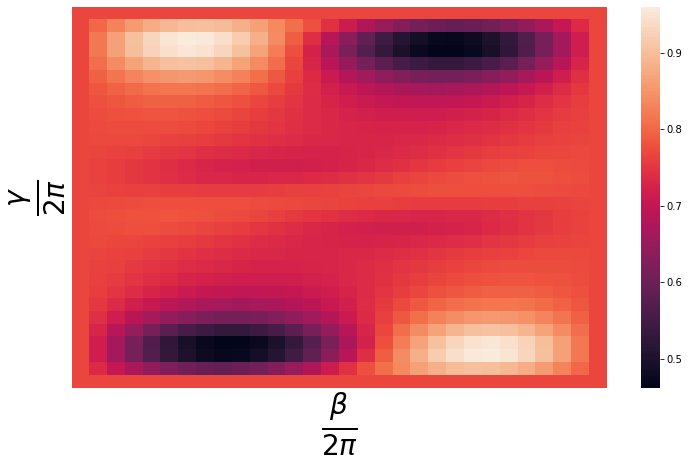

In [39]:
fig, ax = plt.subplots(figsize = (12, 7))
#title = "Energy landscape of subgraph indexed 40"
#plt.title(title, fontsize = 18)
ttl = ax.title
ttl.set_position([0.5, 1.05])


y_ticks = [round(gamma[len(gamma)-i-1],2) for i in range(len(gamma))]
x_ticks = [round(beta[i],2) for i in range(len(beta))]


sns.heatmap(data_1, ax = ax, yticklabels = [], xticklabels = [])#, cbar_kws={label : "Averaage Approximation Ratio"})
cbar = ax.collections[0].colorbar
#cbar.set_label("Average Approximation Ratio")
plt.ylabel(r"$\frac{\gamma}{2\pi}$")
plt.xlabel(r"$\frac{\beta}{2\pi}$")
# ax.set_yticks(y_ticks)
# ax.set_xticks(x_ticks)
plt.show()
fig.savefig("fig_SubgraphUniversality_July22.png", dpi = 100)


In [40]:
a_file = open("UniversalitySubgraphsJuly29.txt", "w")
for row in data_1:
    np.savetxt(a_file, row)
a_file.close()